In [1]:
!pip install wordcloud
!pip install emoji
!pip install gensim
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 4.0 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=560648f9bd20675a29f2bb94c44128e3380e4fc6ededf7164a716667a0ca0079
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 3.9 MB/s 
     |████████████████████████████████| 182 kB 67.7 MB/s 
     |████████████████████████████████| 7.6 MB 47.1 MB/s 


# Task 10 SemEval2023 - Explainable Detection of Online Sexism (EDOS)


## Introduction
Sexism on social media is on the rise. It can negatively impact the mental health of some individuals and the lives of women who are specifically targeted. It may also cause harm by making online spaces inaccessible and unwelcoming, as well as by perpetuating socioeconomic divisions and inequities. Numerous organizations utilized automated technologies to search for and assess sexist content at scale; yet, these systems often provided only broad classifications of content without context or context-specific characteristics. By pointing out sexist content and explaining why it is offensive and unacceptable, we can help users and moderators better understand and accept the decisions made by automated technology. This data can also be used to determine how online movements affect people who have experienced trauma.

The task is described in detail on the [official website](https://codalab.lisn.upsaclay.fr/competitions/7124) for the competition.

According to the organizers the task contains three hierarchical subtasks:


*   **Task A:** Binary classification of whether or not a post is sexist.
*   **Task B:**  A four-class classification for sexist posts in which systems must predict one of four categories:  

  (1) *threats*, (2) *derogation*, (3) *animosity*, (4) *prejudiced discussions*.
*   **Task C:** For sexist posts, an eleven-class classification in which systems must predict one of eleven fine-grained vectors:

  (1.1) threats of harm
  (1.2) incitement and encouragement of harm

  (2.1) descriptive attacks
  (2.2) aggresive and emotive attacks
  (2.3) dehumanisation and overt sexual objectification

  (3.1) casual use of gendered slurs, profanities & insults
  (3.2) immutable gender stereotypes
  (3.3) backhanded gendered compliments
  (3.4) condescending explanations or unwelcome advice

  (4.1) supporting mistreatment of individual or unwelcome advice
  (4.2) supporting systemic discrimination against women



In this notebook, we explore strategies for analyzing the dataset, preprocessing the data, and extracting suitable features for ensemble approaches, and attention-based models.


In [167]:
import os
import sys


import re
import csv
import string
import unicodedata


import numpy                                                 as np
import pandas                                                as pd
from collections import Counter


import seaborn                                               as sns
import matplotlib
import matplotlib.pyplot                                     as plt
from matplotlib import colors

import gensim
import gensim.parsing.preprocessing                          as gsp
from gensim import utils
from gensim.summarization.textcleaner import split_sentences

from wordcloud import WordCloud

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore") 

In [148]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('universal_tagset')
nltk.download("averaged_perceptron_tagger")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Exploratory Data Analysis



In [7]:
raw_train_data = pd.read_csv('/content/drive/MyDrive/NLP2/train_all_tasks.csv')
raw_train_data.head(25)

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none
5,sexism2022_english-10376,yeah but in order to keep the benefit i have t...,not sexist,none,none
6,sexism2022_english-4569,Hahaha I just wish they would live their truth...,not sexist,none,none
7,sexism2022_english-91,head mod said she talked to him after he made ...,not sexist,none,none
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
9,sexism2022_english-16316,We most definitely did. I didn’t go too much i...,not sexist,none,none


In [8]:
raw_test_data_taskA = pd.read_csv('/content/drive/MyDrive/NLP2/Test/dev_task_a_entries.csv')
raw_test_data_taskB = pd.read_csv('/content/drive/MyDrive/NLP2/Test/dev_task_b_entries.csv')
raw_test_data_taskC = pd.read_csv('/content/drive/MyDrive/NLP2/Test/dev_task_c_entries.csv')

In [9]:
pd.set_option("display.max_colwidth", -1)
print(raw_train_data["text"].head(25))

0     Damn, this writing was pretty chaotic                                                                                                                                                                                                  
1     Yeah, and apparently a bunch of misogynistic virgins are the ones to turn a gay woman straight, lol                                                                                                                                    
2     How the FUCK is this woman still an MP!!!???                                                                                                                                                                                           
3     Understand. Know you're right. At same time I know there isn't enough money in the world to induce me to do an beastly female equivalent.                                                                                              
4     Surprized they didn't stop and rape some w

In [10]:
raw_train_data.describe(include = "all")

,rewire_id,text,label_sexist,label_category,label_vector
count,14000,14000,14000,14000,14000
unique,14000,14000,2,5,12
top,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
freq,1,1,10602,10602,10602


## Data Cleaning

Before proceeding with further analysis of the dataset, it is required to clean and preprocess the data:


1.   Since the 'text' column is the most important information in the dataset, we will delete any duplicate rows. Since there are no missing data, we shall skip the pre-processing stage in which missing information is removed.
2.   The text is decoded, and normalized, meaning that complicated symbols are turned into simple characters. Characters can be encoded in several ways, including "Latin," "ISO/IEC 8859-1," etc. Therefore, it is important to ensure comprehensive data in a standard encoding format for better analysis. We select UTF-8 encoding for this project because it is widely accepted and utilized.
3.   We substitute emoticons and emojis with their respective descriptors.



In [11]:
# STEP 1 - skip for test data
raw_train_data.drop_duplicates(subset = ["text"], inplace = True)
print("Number of training samples: ", len(raw_train_data))

Number of training samples:  14000


In [12]:
print("Number of test samples for task A: ", len(raw_test_data_taskA))
print("Number of test samples for task B: ", len(raw_test_data_taskB))
print("Number of test samples for task C: ", len(raw_test_data_taskC))

Number of test samples for task A:  2000
Number of test samples for task B:  486
Number of test samples for task C:  486


In [13]:
# STEP 2
def normalize_text(txt):
  txt = unicodedata.normalize('NFKD', txt).encode('ascii', 'ignore').decode('UTF-8', 'ignore')
  return txt

raw_train_data["text"] = raw_train_data["text"].apply(normalize_text)
raw_test_data_taskA["text"] = raw_test_data_taskA["text"].apply(normalize_text)
raw_test_data_taskB["text"] = raw_test_data_taskB["text"].apply(normalize_text)
raw_test_data_taskC["text"] = raw_test_data_taskC["text"].apply(normalize_text)

In [14]:
# Samples after normalizing the train data
pd.set_option("display.max_colwidth", -1)
print(raw_train_data["text"].head(20))

0     Damn, this writing was pretty chaotic                                                                                                                                                                                                  
1     Yeah, and apparently a bunch of misogynistic virgins are the ones to turn a gay woman straight, lol                                                                                                                                    
2     How the FUCK is this woman still an MP!!!???                                                                                                                                                                                           
3     Understand. Know you're right. At same time I know there isn't enough money in the world to induce me to do an beastly female equivalent.                                                                                              
4     Surprized they didn't stop and rape some w

In [15]:
# Samples after normalizing the test data
pd.set_option("display.max_colwidth", -1)
print(raw_test_data_taskA["text"].head(10))

0    I do not try to hard. I do what guys who get with girls do, according to those guys (many if my friends). I also have female friends. To be Asian is to be asexual to women                                          
1    That sucks. We elected a Navy Seal in Missouri, and he was awesome... except that he cheated on his wife a few years before he became Governor. And, the swamp destroyed him and he resigned this summer. Damn shame.
2    Walk away and never look back. If she reaches out, set a date and hang out, have fun and hook up. And start following Coach Corey Wayne.                                                                             
3    basically I placed more value on her than I should then?                                                                                                                                                             
4    NYT and Asian "part ways." But why on earth was she hired in the first place? (ANSWER: she's NOT WHITE.) [URL]         

In [16]:
# Samples after normalizing the test data
pd.set_option("display.max_colwidth", -1)
print(raw_test_data_taskB["text"].head(10))

0    Every woman wants to be a model. It's codeword for "I get everything for free and people want me"                                                                                                                                                         
1    Poor dude hasn't realized you dont share emotions with women. Sadistic little bitches will throw it in your face everytime and make you feel like shit for it. Only share emotions with other men that you trust.                                         
2    Can women be loyal? If you make them loyal. Just understand that most women in the Modern World are dogshit.                                                                                                                                              
3    Lefties; we havent been outraged for an hour. Hold on, princess Michael of Kent wore what? BURN HER BURN HER.                                                                                                                      

In [17]:
# Samples after normalizing the test data
pd.set_option("display.max_colwidth", -1)
print(raw_test_data_taskC["text"].head(10))

0    Every woman wants to be a model. It's codeword for "I get everything for free and people want me"                                                                                                                                                         
1    Poor dude hasn't realized you dont share emotions with women. Sadistic little bitches will throw it in your face everytime and make you feel like shit for it. Only share emotions with other men that you trust.                                         
2    Can women be loyal? If you make them loyal. Just understand that most women in the Modern World are dogshit.                                                                                                                                              
3    Lefties; we havent been outraged for an hour. Hold on, princess Michael of Kent wore what? BURN HER BURN HER.                                                                                                                      

In [18]:
"""
    Emoticons data
"""

from emoji import demojize

EMOTICONS = [
    ("Laughing", r':[‑,-]?\){2,}'),
    ("Rolling_on_the_floor_laughing", r'\=\){2,}|\=\]'),
    ("Heart", r'<3'),
    ("Broken_heart", r'<\\3'),
    ('Very_happy', r':[‑,-]?D'),
    ('Happy_face_or_smiley', r'[:,8,=][‑,-,o,O]?\)|\(\^[v,u,o,O]\^\)|:[‑,-]?3'),
    ('Happy', r'=]'),
    ('Mischievous_smile', r':[‑,-]?>'),
    ('Sticking_tongue_out_playfulness_or_cheekiness', r':P|:[‑,-]P|;P|:b|:-b'),
    ('Kiss', r':[‑,-]?[\*,X,x]'),
    ('Joy', r' uwu | UwU '),
    ('Surprised_or_shock', r':[‑,-]?[o|O|0]|o_O|o_0'),
    ('Sad_frown_andry_or_pouting', r':[‑,-]?\('),
    ('Very_sad', r':[(]{2,}'),
    ('Crying', r':[‑,-]?\'\('),
    ('Straight_face_no_expression_dissaproval_or_not_funny', r':[‑,-]?\|'),
    ('Annoyed_or_hesitant', r'>?[:][\\|\/]|\=\/|=\\'),
    ('Angel_saint_or_innocent', r'[0,O,o]:[‑,-]?[\),3]'),
    ('Embarrassed_or_blushing', r':\$'),
    ('Sad_or_crying', r';_;|\(;_;\)|\(\'_\'\)|Q_Q|\(;_:\)|\(:_;\)'),
    ('Evil_or_devilish', r'[>|}|3]:[‑,-]?\)'),
    ('Laughing_big_grin_or_laugh_with_glasses', r'[:,8,X,=][-,‑]?[D,3]|B\^D'),
    ('Tears_of_happiness', r':[\',\`][‑,-]?\)'),
    ('Horror', r'D[-,‑]\''),
    ('Great_dismay', r'D[8,;,=]'),
    ('Tongue_in_cheek', r':[-,‑]J'),
    ('Yawn', r'8[‑,-]0|>:O'),
    ('Sadness', r'D:'),
    ('Disgust', r'D:<'),
    ('Cool', r'\|;[‑,-]\)'),
    ('Drunk_or_confused', r'%[-,‑]?\)'),
    ('Sealed_lips_or_wearing_braces_or_tongue_tied', r':[-,‑]?[x,#,&]'),
    ('Skeptical_annoyed_undecided_uneasy_or_hesitant', r':[-,‑]?[.,/]|:[L,S]|=[/,L]'),
    ('Scepticism_disbelief_or_disapproval', r'\',:-\||\',:[-,-]'),
    ('Party_all_night', r'#‑\)'),
    ('Headphones_listening_to_music', r'\(\(d\[-_-\]b\)\)'),
    ('Bored', r'\|‑O'),
    ('Dump', r'<:‑\|'),
    ('Being_sick', r':-?#{2,3}..'),
    ('Amazed', r'\(\*_\*\)|\(\+_\+\)|\(\@_\@\)'),
    ('Confusion', r'\(\?_\?\)|\(\・\・?'),
    ('Wink_or_smirk', r';[-,‑]?[\),D,\]]|\*[-,‑]?\)|;\^\)|:‑,|;3'),
    ('Exciting', r'\\\(\^o\^\)\/|\\\(\^o\^\)\／|ヽ\(\^o\^\)丿|\(\*^0^\*\)|＼\(-o-\)／|＼\(~o~\)\／'),
    ('Giggling_with_hand_covering_mouth', r'\^m\^'),
    ('Joyful', r'\(\^_\^\)/|\(\^[O,o]\^\)／|\(°o°\)'),
    ('Tired', r'\(=_=\)'),
    ('Shame', r'\(-_-\)|\(一_一\)'),
    ('Surprised', r'\(o\.o\)'),
    ('Sleeping', r'\(-_-\)zzz'),
    # ('Kowtow_as_a_sign_of_respect_or_dogeza_for_apology', r'\(__\)|_\(\._\.\)_|<\(_ _\)>|m\(_ _\)m|m\(__\)m||_\(_\^_\)_'),
    ('Troubled', r'\(>_<\)>?'),
    ('Nervous__Embarrassed_Troubled_Shy_Sweat_drop', r'\(-_-;\)|\(\^_\^;\)|\(-_-;\)|\(~_~;\)|\(・.・;\)|\(・_・;\)'),
    ('Wink', r'\(\^_-\)'),
    ('Normal_laugh', r'>\^_\^<|<\^!\^>|\(\^\.\^\)|\(\^J\^\)|\(\*\^[_,.]\^\*\)|\(\^<\^\)|\(\^\.\^\)|\(#\^\.\^#\)'),
    ('STH_ELSE', r'.')
]

emoticons_tokens = '|'.join('(?P<%s>%s)' % emoticon for emoticon in EMOTICONS)

def replace_emoticons(text):
    new_text = ""
    for match in re.finditer(emoticons_tokens, text):
        emoticon_name = match.lastgroup
        emoticon = match.group(emoticon_name)
        if emoticon_name == 'STH_ELSE':
            new_text += emoticon
        else:
            new_text += emoticon_name
    return new_text

In [19]:
# STEP 3
raw_train_data["text"] = raw_train_data["text"].apply(replace_emoticons)
raw_test_data_taskA["text"] = raw_test_data_taskA["text"].apply(replace_emoticons)
raw_test_data_taskB["text"] = raw_test_data_taskB["text"].apply(replace_emoticons)
raw_test_data_taskC["text"] = raw_test_data_taskC["text"].apply(replace_emoticons)

raw_train_data["text"] = raw_train_data["text"].apply(demojize)
raw_test_data_taskA["text"] = raw_test_data_taskA["text"].apply(demojize)
raw_test_data_taskB["text"] = raw_test_data_taskB["text"].apply(demojize)
raw_test_data_taskC["text"] = raw_test_data_taskC["text"].apply(demojize)

In [20]:
# Samples after completing all train data cleaning steps
pd.set_option("display.max_colwidth", -1)
print(raw_train_data["text"].head(7))

0    Damn, this writing was pretty chaotic                                                                                                    
1    Yeah, and apparently a bunch of misogynistic virgins are the ones to turn a gay woman straight, lol                                      
2    How the FUCK is this woman still an MP!!!???                                                                                             
3    Understand. Know you're right. At same time I know there isn't enough money in the world to induce me to do an beastly female equivalent.
4    Surprized they didn't stop and rape some women                                                                                           
5    yeah but in order to keep the benefit i have to be good tommorow because i told her we could try                                         
6    Hahaha I just wish they would live their truth and cut the shit, so we wouldn't have to worry about these mfs being out in society.      

In [21]:
# Samples after completing all test data cleaning steps
pd.set_option("display.max_colwidth", -1)
print(raw_test_data_taskC["text"].head(7))

0    Every woman wants to be a model. It's codeword for "I get everything for free and people want me"                                                                                                                              
1    Poor dude hasn't realized you dont share emotions with women. Sadistic little bitches will throw it in your face everytime and make you feel like shit for it. Only share emotions with other men that you trust.              
2    Can women be loyal? If you make them loyal. Just understand that most women in the Modern World are dogshit.                                                                                                                   
3    Lefties; we havent been outraged for an hour. Hold on, princess Michael of Kent wore what? BURN HER BURN HER.                                                                                                                  
4    That slag has some nerve showing her face. Bitch is supposed to be a mother. Sh

## Data Exploration

### Sexism vs Non-sexism - 

In [22]:
print("Count of posts pertaining to sexism in the provided dataset:")
print(raw_train_data["label_sexist"].value_counts())

Count of posts pertaining to sexism in the provided dataset:
not sexist    10602
sexist        3398 
Name: label_sexist, dtype: int64


#### Train Data

##### Task A

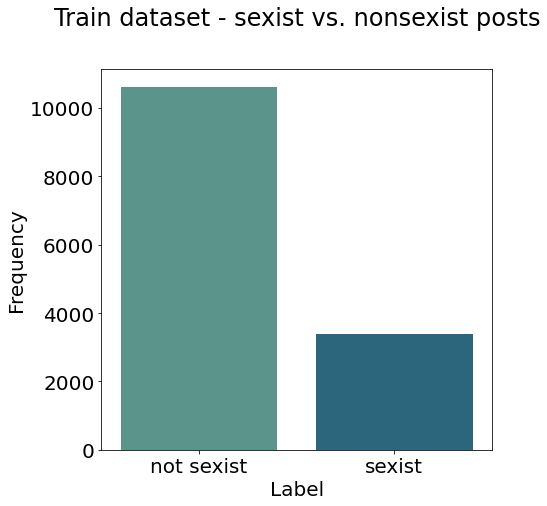

In [23]:
plt.figure(figsize = (7, 7))
sns.countplot(raw_train_data["label_sexist"], palette = "crest")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Train dataset - sexist vs. nonsexist posts", y=1.1)
plt.show()

##### Task B

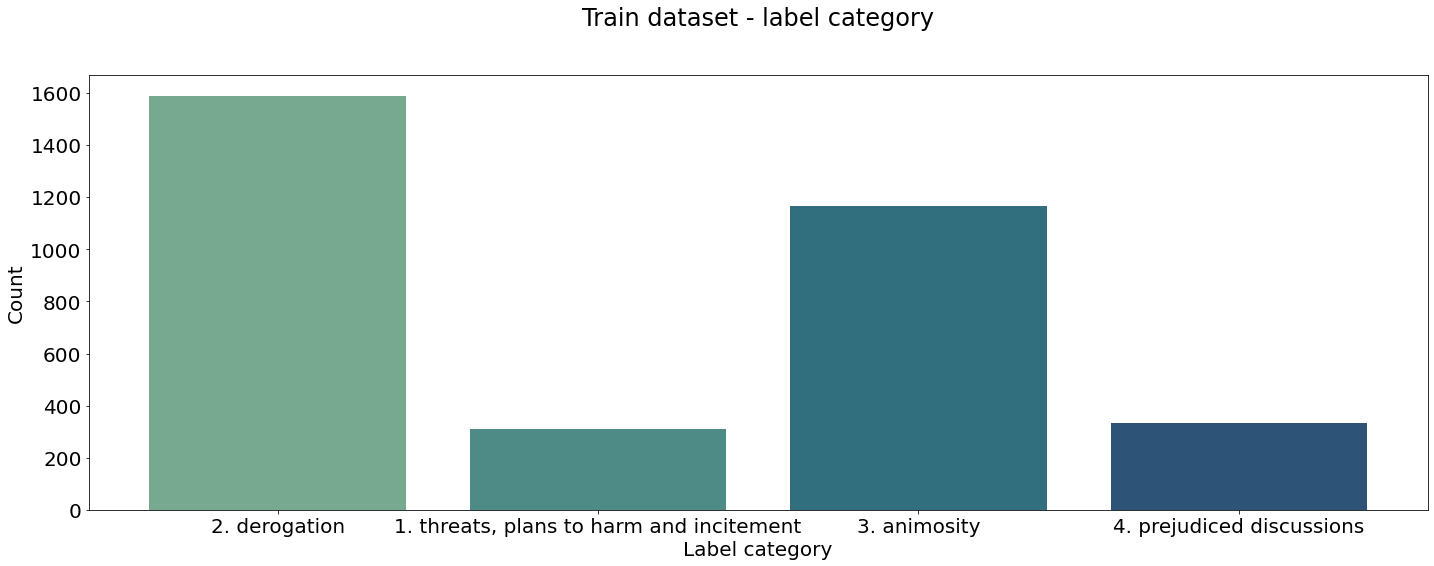

In [24]:
plt.figure(figsize = (24, 8))
sns.countplot(raw_train_data[raw_train_data['label_sexist'] == 'sexist']["label_category"], palette = "crest")
plt.xlabel("Label category")
plt.ylabel("Count")
plt.title("Train dataset - label category", y=1.1)
plt.autoscale(enable = True)
plt.show()

##### Task C

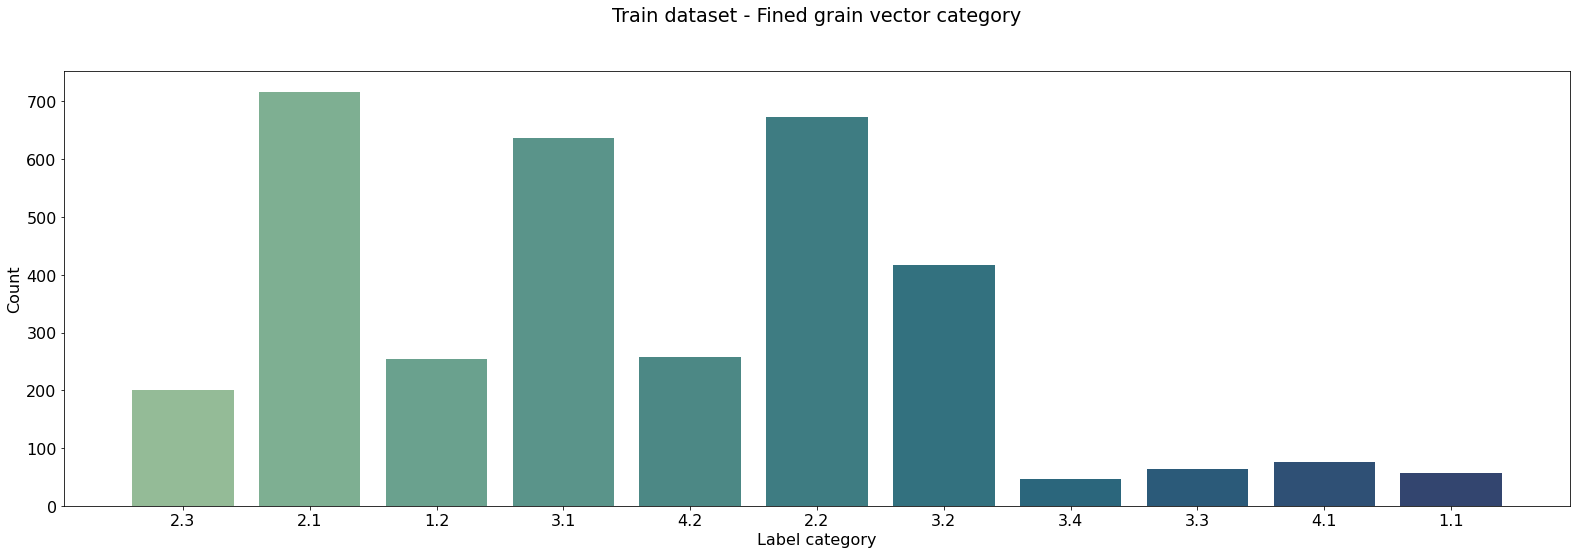

In [25]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize = (27, 8))
sns.countplot(raw_train_data[raw_train_data['label_sexist'] == 'sexist']["label_vector"].apply(lambda x: str(x)[:3]), palette = "crest")
plt.xlabel("Label category")
plt.ylabel("Count")
plt.title("Train dataset - Fined grain vector category", y=1.1)
plt.autoscale(enable = True)
plt.show()

### Exploring relevant data characteristics

We will develop some additional characteristics that provide relevant information about the composition of our data. Particularly, we will examine the distribution of the textual characteristics of user-posted content in order to determine the key insights regarding data distribution. This step is essential owing to its effects on the outcomes. It tells us what kind of data transformation to use, what features to extract, and which hyperparameters to choose.

The number of intervals selected for the histogram is determined by the information to be retrieved. The number of intervals is defined as follows:
$$ Δ = 1 + 3,3 * ln(n) $$

where *n* is the number of observations.

#### Train Data

Number of characters present in every train sample:

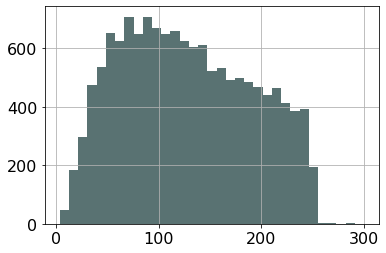

In [26]:
raw_train_data["text"].str.len().hist(grid = True, bins = 33, color = "darkslategray", alpha = 0.8)

Statistical count features in the posts:
- Total number of characters excluding whitespace and digits
- Number of words
- Mean word length
- Number of sentences
- Mean sentence length
- Number of characters excluding special characters
- Number of special characters (punctuation and numbers)
- Number of stopwords
- The ratio of the number of sentences to the total number of words


In [27]:
train_data = raw_train_data.copy()

In [28]:
SPECIAL_CHARACTERS = string.punctuation + string.digits

# total number of characters excluding whitespace and digits in train data
train_data["characters count"] = train_data["text"].apply(lambda x: len(x.replace("\d| |\n|\r|\r\n", "")))
# number of characters excluding special characters
train_data["excluded characters count"] = train_data["text"].apply(lambda x: len(x.replace(SPECIAL_CHARACTERS, "")))
# number of special characters
train_data["special characters count"] = train_data["text"].apply(lambda x: len([chr for chr in x if chr in SPECIAL_CHARACTERS]))
# number of words in train data
train_data["words count"] = train_data["text"].apply(lambda x: len(x.split()))
# mean words length
train_data["mean word length"] = train_data["text"].apply(lambda x: np.mean([len(word) for word in x]))
# number of sentences in train data
train_data["sentences count"] = train_data["text"].apply(lambda x: len(split_sentences(x)))
# mean sentence length
train_data["mean sentence length"] = train_data["text"].apply(lambda x: np.mean([len(sent) for sent in split_sentences(x)]))
# sentence density
train_data["sentences density"] = train_data["sentences count"] / train_data["words count"]

In [29]:
# total number of stopwords in the train data
STOPWORDS = set(stopwords.words("english"))

def count_stopwords(text):
  word_tokens = word_tokenize(text)
  stopwords_tokens = [stopword_token for stopword_token in word_tokens if stopword_token in STOPWORDS]
  return len(stopwords_tokens)

train_data["stopwords count"] = train_data["text"].apply(lambda x: count_stopwords(x))

Analyze the distribution of features in plain text

In [30]:
train_data[['characters count', 'excluded characters count', 'special characters count', 'words count', 'mean word length', \
            'stopwords count', 'sentences count', 'mean sentence length', 'sentences density']].describe()

,characters count,excluded characters count,special characters count,words count,mean word length,stopwords count,sentences count,mean sentence length,sentences density
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.0,14000.000000,14000.000000,14000.000000,14000.000000
mean,127.765929,127.765929,5.283500,23.397714,1.0,9.591643,2.106714,69.032799,0.107230
std,63.086145,63.086145,4.178083,11.658104,0.0,5.916608,1.173333,40.708233,0.071884
min,4.000000,4.000000,0.000000,1.000000,1.0,0.000000,1.000000,4.000000,0.018182
25%,75.000000,75.000000,2.000000,14.000000,1.0,5.000000,1.000000,41.500000,0.064516
50%,122.000000,122.000000,4.000000,22.000000,1.0,9.000000,2.000000,59.000000,0.090909
75%,179.000000,179.000000,7.000000,33.000000,1.0,14.000000,3.000000,84.000000,0.128205
max,300.000000,300.000000,53.000000,55.000000,1.0,31.000000,14.000000,286.000000,1.000000


In [31]:
new_features = {
  'characters count': 'Number of characters in users\' posts excluding whitespaces and numbers',
  'excluded characters count': 'Number of characters in users\' posts excluding punctuation',
  'special characters count': 'Number of special characters (punctuation and digits) in each posts',
  'words count': 'Number of words in each post',
  'stopwords count': 'Number of stopwords in each post',
  'sentences count': 'Number of sentences in each post',
}

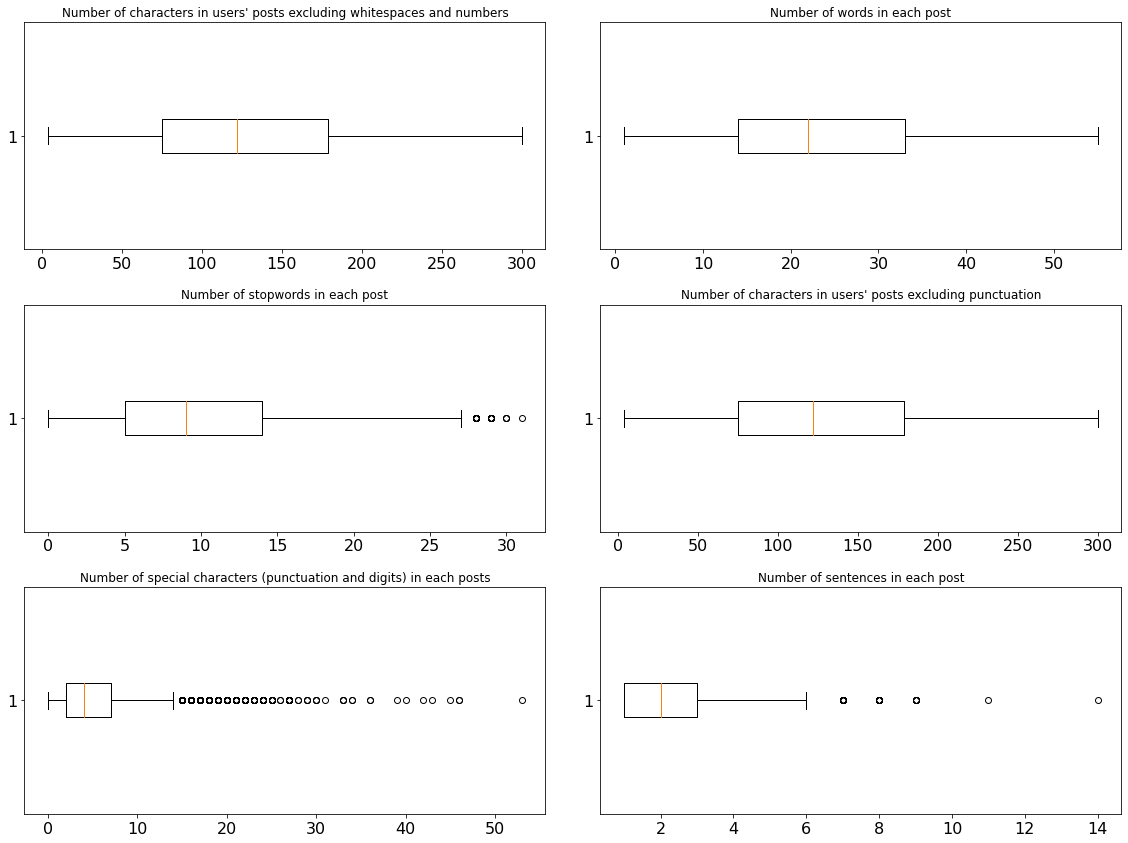

<Figure size 1152x7200 with 0 Axes>

In [32]:
fig, axes = plt.subplots(int(len(new_features) // 2), 2, figsize=(16, 12))

for idx, feature in enumerate(new_features):
  axes[idx % (len(new_features) // 2), idx % 2].grid(False)
  axes[idx % (len(new_features) // 2), idx % 2].set_title(new_features[feature], fontsize = 12)
  axes[idx % (len(new_features) // 2), idx % 2].boxplot(train_data[feature], vert = False)

fig.tight_layout()
plt.figure(figsize = (16, 100))
plt.show()

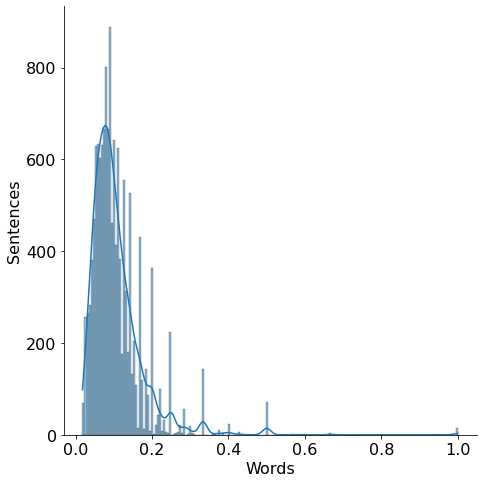

In [33]:
fig = sns.displot(train_data["sentences density"], kde=True, height=7)
plt.xlabel('Words')
plt.ylabel('Sentences')
plt.show()

Extract hashtags from all train posts:

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(train_data["text"].str.extractall(r'(\#\w+)')[0].value_counts())

#MAGA                                      106
#GabFam                                    74 
#Trump                                     66 
#SpeakFreely                               37 
#News                                      26 
#x200B                                     24 
#DrainTheSwamp                             20 
#Hillary                                   16 
#AltRight                                  16 
#Gab                                       16 
#FakeNews                                  15 
#PresidentTrump                            13 
#PizzaGate                                 12 
#BritFam                                   12 
#NSFW                                      11 
#1                                         10 
#BanIslam                                  10 
#Islam                                     8  
#Muslim                                    8  
#MeToo                                     8  
#TRUMP                                     7  
#Russia      

##### Task A

Number of characters:

In [35]:
posts_df = raw_train_data.groupby("label_sexist")
posts_df.groups.keys()
list(posts_df.groups)

['not sexist', 'sexist']

<function matplotlib.pyplot.show(*args, **kw)>

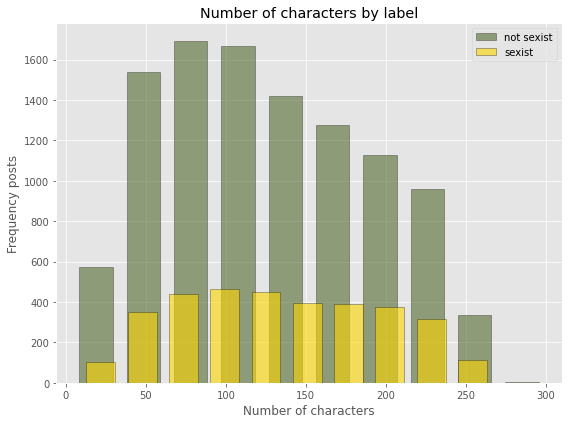

In [36]:
plt.figure(figsize = (8, 6))
plt.style.use('ggplot')
plt.title('Number of characters by label')

plt.hist(posts_df.get_group('not sexist')['text'].str.len(), edgecolor = 'black', color = 'darkolivegreen', rwidth = .7, alpha = .6, label = 'not sexist')
plt.hist(posts_df.get_group('sexist')['text'].str.len(), edgecolor = 'black', color = 'gold', rwidth = .7, alpha = .6, label = 'sexist')

plt.legend(loc = 'upper right')
plt.xlabel('Number of characters')
plt.ylabel('Frequency posts')

plt.tight_layout()
plt.show

Text(0.5, 0.98, 'Number of words in sexist posts')

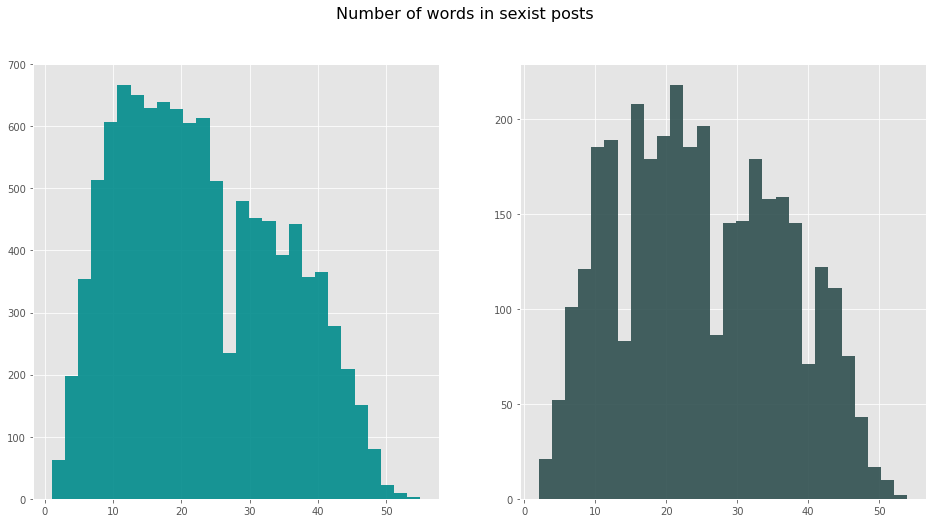

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
train_data[train_data['label_sexist'] == 'not sexist']['words count'].hist(bins = 28, ax=ax1, color ='darkcyan', grid = True, alpha = 0.9)
train_data[train_data['label_sexist'] == 'sexist']['words count'].hist(bins = 28, ax=ax2, color = 'darkslategray', grid = True, alpha = 0.9)
plt.suptitle('Number of words in sexist posts', fontsize = 16)

In [38]:
train_data[['characters count', 'excluded characters count', 'special characters count']].groupby(train_data['label_sexist']).describe()

characters count                                                  \
                        count        mean        std  min   25%    50%    75%   
label_sexist                                                                    
not sexist    10602.0          125.404546  63.287647  4.0  73.0  120.0  176.0   
sexist        3398.0           135.133608  61.885898  9.0  84.0  132.0  186.0   

                    excluded characters count              ...                \
                max                     count        mean  ...    75%    max   
label_sexist                                               ...                 
not sexist    300.0  10602.0                   125.404546  ...  176.0  300.0   
sexist        267.0  3398.0                    135.133608  ...  186.0  267.0   

             special characters count                                          \
                                count      mean       std  min  25%  50%  75%   
label_sexist                                                                    
not sexist    10602.0                  5.329466  4.258333  0.0  2.0  4.0  7.0   
sexist        3398.0                   5.140082  3.914276  0.0  2.0  4.0  7.0   

                    
               max  
label_sexist        
not sexist    53.0  
sexist        46.0  

[2 rows x 24 columns]

In [39]:
train_data[['words count', 'stopwords count']].groupby(train_data['label_sexist']).describe()

words count                                                     \
                   count       mean        std  min   25%   50%   75%   max   
label_sexist                                                                  
not sexist    10602.0     22.905584  11.648220  1.0  13.0  22.0  32.0  55.0   
sexist        3398.0      24.933196  11.556644  2.0  15.0  24.0  34.0  54.0   

             stopwords count                                                   
                       count       mean       std  min  25%   50%   75%   max  
label_sexist                                                                   
not sexist    10602.0         9.333616   5.915585  0.0  5.0  8.0   13.0  31.0  
sexist        3398.0          10.396704  5.847922  0.0  6.0  10.0  15.0  30.0

In [40]:
train_data[['sentences count']].groupby(train_data['label_sexist']).describe()

sentences count                                              
                       count      mean       std  min  25%  50%  75%   max
label_sexist                                                              
not sexist    10602.0         2.075646  1.154646  1.0  1.0  2.0  3.0  14.0
sexist        3398.0          2.203649  1.224934  1.0  1.0  2.0  3.0  11.0

In [41]:
# Hash tags for 'sexist' posts
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(train_data[train_data['label_sexist'] == 'sexist']["text"].str.extractall(r'(\#\w+)')[0].value_counts())

#MAGA                             18
#x200B                            12
#GabFam                           10
#Trump                            10
#SpeakFreely                      8 
#Gab                              5 
#redpill                          4 
#NSFW                             4 
#MGTOW                            4 
#FakeNews                         4 
#MeToo                            3 
#News                             3 
#TeamSmut                         3 
#AltRight                         3 
#feminism                         3 
#Feminism                         3 
#feminazi                         3 
#mgtow                            3 
#feminists                        3 
#MRAs                             2 
#Christianity                     2 
#sexy                             2 
#girls                            2 
#AusPol                           2 
#AusFam                           2 
#erotica                          2 
#CNN                              2 
#

In [42]:
# Hash tags for 'not sexist' posts
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(train_data[train_data['label_sexist'] == 'not sexist']["text"].str.extractall(r'(\#\w+)')[0].value_counts())

#MAGA                                      88
#GabFam                                    64
#Trump                                     56
#SpeakFreely                               29
#News                                      23
#DrainTheSwamp                             18
#Hillary                                   15
#AltRight                                  13
#x200B                                     12
#PresidentTrump                            12
#FakeNews                                  11
#PizzaGate                                 11
#Gab                                       11
#BritFam                                   10
#BanIslam                                  10
#Muslim                                    8 
#1                                         8 
#NSFW                                      7 
#Islam                                     7 
#Russia                                    6 
#pizzagate                                 6 
#TRUMP                            

##### Task B

In [43]:
posts_df = raw_train_data.groupby("label_category")
posts_df.groups.keys()
list(posts_df.groups)

['1. threats, plans to harm and incitement',
 '2. derogation',
 '3. animosity',
 '4. prejudiced discussions',
 'none']

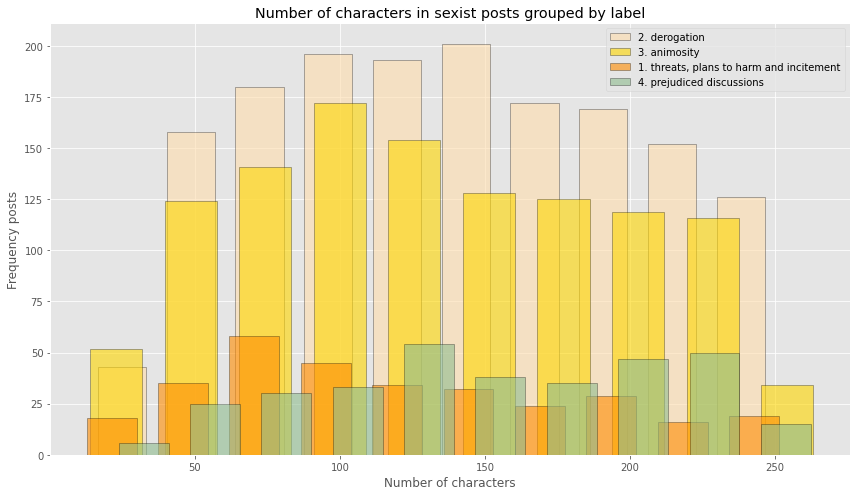

In [44]:
plt.style.use('ggplot')
plt.figure(figsize = (12, 7))
plt.title('Number of characters in sexist posts grouped by label')

plt.hist(posts_df.get_group('2. derogation')['text'].str.len(), edgecolor = 'black', color = 'navajowhite', rwidth = .7, alpha = .6, label = '2. derogation')
plt.hist(posts_df.get_group('3. animosity')['text'].str.len(), edgecolor = 'black', color = 'gold', rwidth = .7, alpha = .6, label = '3. animosity')
plt.hist(posts_df.get_group('1. threats, plans to harm and incitement')['text'].str.len(), edgecolor = 'black', color = 'darkorange', rwidth = .7, alpha = .6, label = '1. threats, plans to harm and incitement')
plt.hist(posts_df.get_group('4. prejudiced discussions')['text'].str.len(), edgecolor = 'black', color = 'darkseagreen', rwidth = .7, alpha = .6, label = '4. prejudiced discussions')

plt.legend(loc = 'upper right')
plt.xlabel('Number of characters')
plt.ylabel('Frequency posts')

plt.tight_layout()
plt.show()

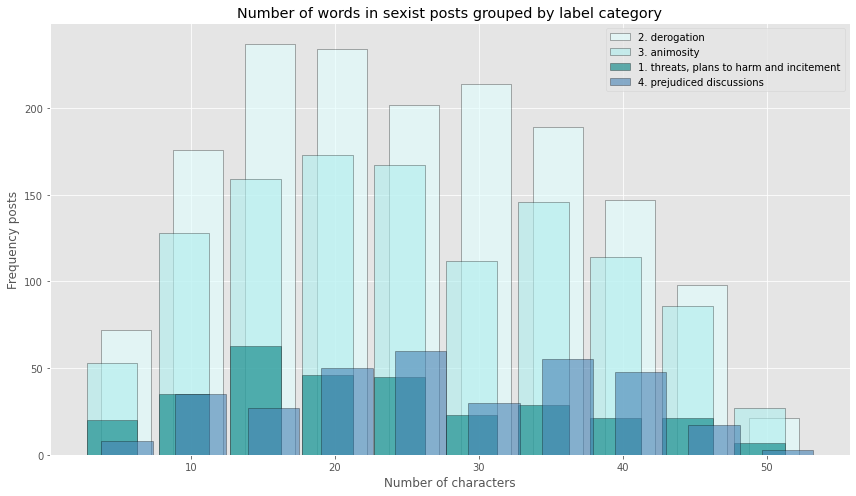

In [45]:
posts_df = train_data.copy().groupby("label_category")

plt.style.use('ggplot')
plt.figure(figsize = (12, 7))
plt.title('Number of words in sexist posts grouped by label category')

plt.hist(posts_df.get_group('2. derogation')['words count'], edgecolor = 'black', color = 'lightcyan', rwidth = .7, alpha = .6, label = '2. derogation')
plt.hist(posts_df.get_group('3. animosity')['words count'], edgecolor = 'black', color = 'paleturquoise', rwidth = .7, alpha = .6, label = '3. animosity')
plt.hist(posts_df.get_group('1. threats, plans to harm and incitement')['words count'], edgecolor = 'black', color = 'teal', rwidth = .7, alpha = .6, label = '1. threats, plans to harm and incitement')
plt.hist(posts_df.get_group('4. prejudiced discussions')['words count'], edgecolor = 'black', color = 'steelblue', rwidth = .7, alpha = .6, label = '4. prejudiced discussions')

plt.legend(loc = 'upper right')
plt.xlabel('Number of characters')
plt.ylabel('Frequency posts')

plt.tight_layout()
plt.show()

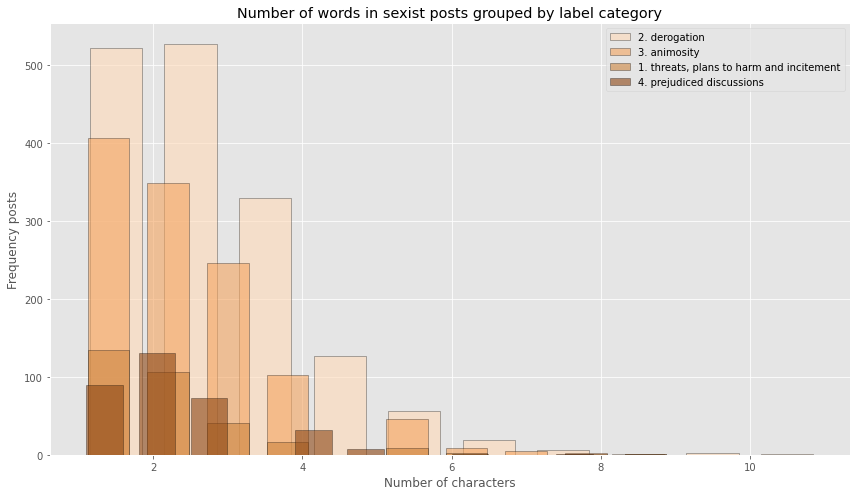

In [46]:
posts_df = train_data.copy().groupby("label_category")

plt.style.use('ggplot')
plt.figure(figsize = (12, 7))
plt.title('Number of words in sexist posts grouped by label category')

plt.hist(posts_df.get_group('2. derogation')['sentences count'], edgecolor = 'black', color = 'peachpuff', rwidth = .7, alpha = .6, label = '2. derogation')
plt.hist(posts_df.get_group('3. animosity')['sentences count'], edgecolor = 'black', color = 'sandybrown', rwidth = .7, alpha = .6, label = '3. animosity')
plt.hist(posts_df.get_group('1. threats, plans to harm and incitement')['sentences count'], edgecolor = 'black', color = 'peru', rwidth = .7, alpha = .6, label = '1. threats, plans to harm and incitement')
plt.hist(posts_df.get_group('4. prejudiced discussions')['sentences count'], edgecolor = 'black', color = 'saddlebrown', rwidth = .7, alpha = .6, label = '4. prejudiced discussions')

plt.legend(loc = 'upper right')
plt.xlabel('Number of characters')
plt.ylabel('Frequency posts')

plt.tight_layout()
plt.show()

##### Task C

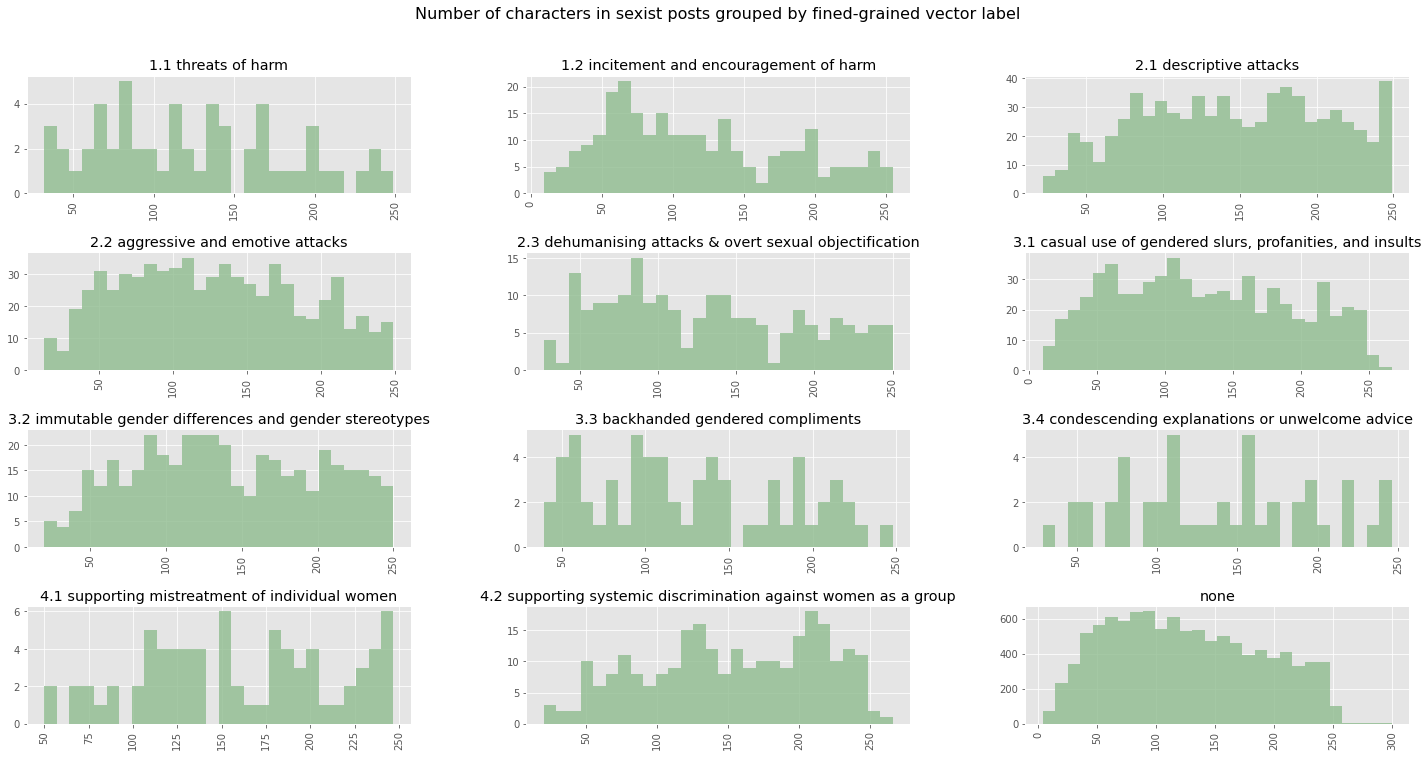

In [47]:
axes_subplot_list = raw_train_data['text'].str.len().hist(by = raw_train_data['label_vector'], figsize=(24, 12), bins = 28, alpha = .8, color = 'darkseagreen')
plt.suptitle('Number of characters in sexist posts grouped by fined-grained vector label', fontsize = 16)
plt.show()

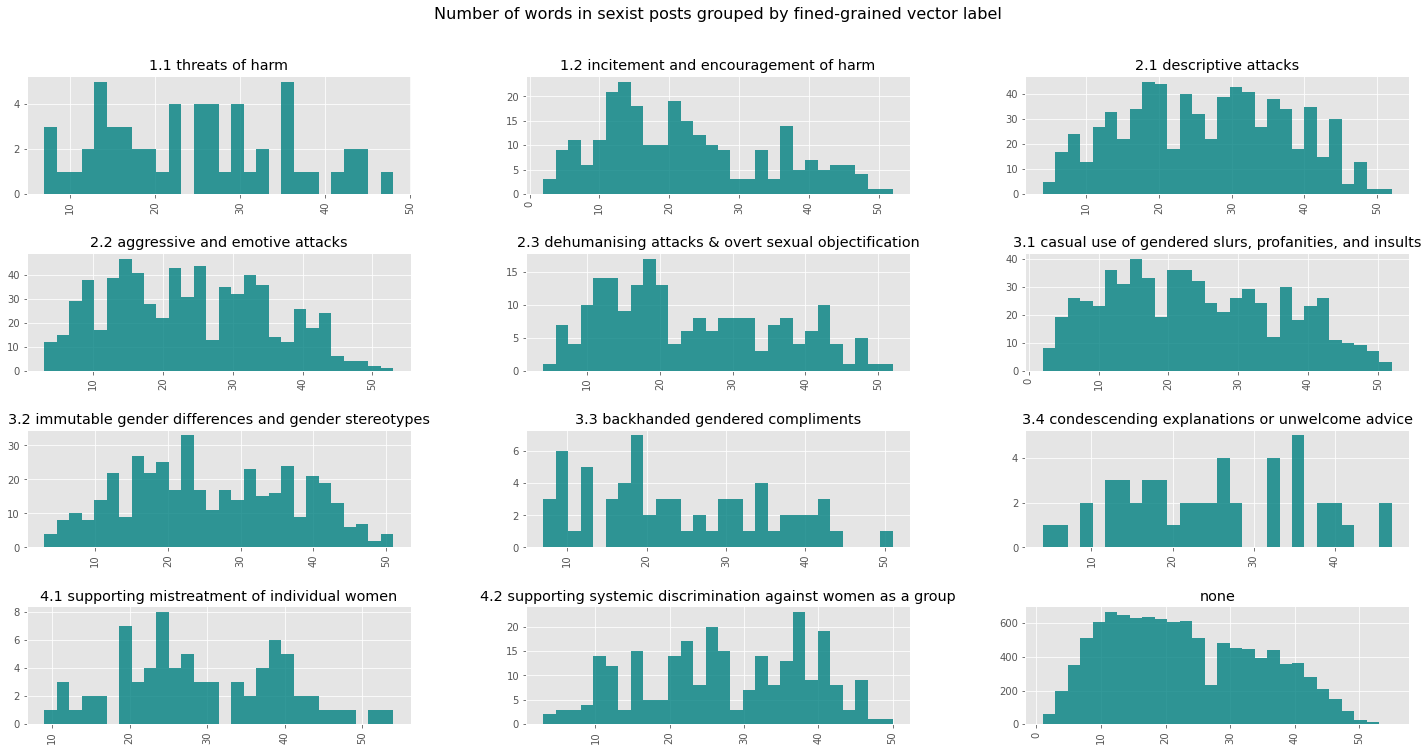

In [48]:
axes_subplot_list = train_data['words count'].hist(by = train_data['label_vector'], figsize=(24, 12), bins = 28, alpha = .8, color = 'teal')
plt.suptitle('Number of words in sexist posts grouped by fined-grained vector label', fontsize = 16)
plt.show()

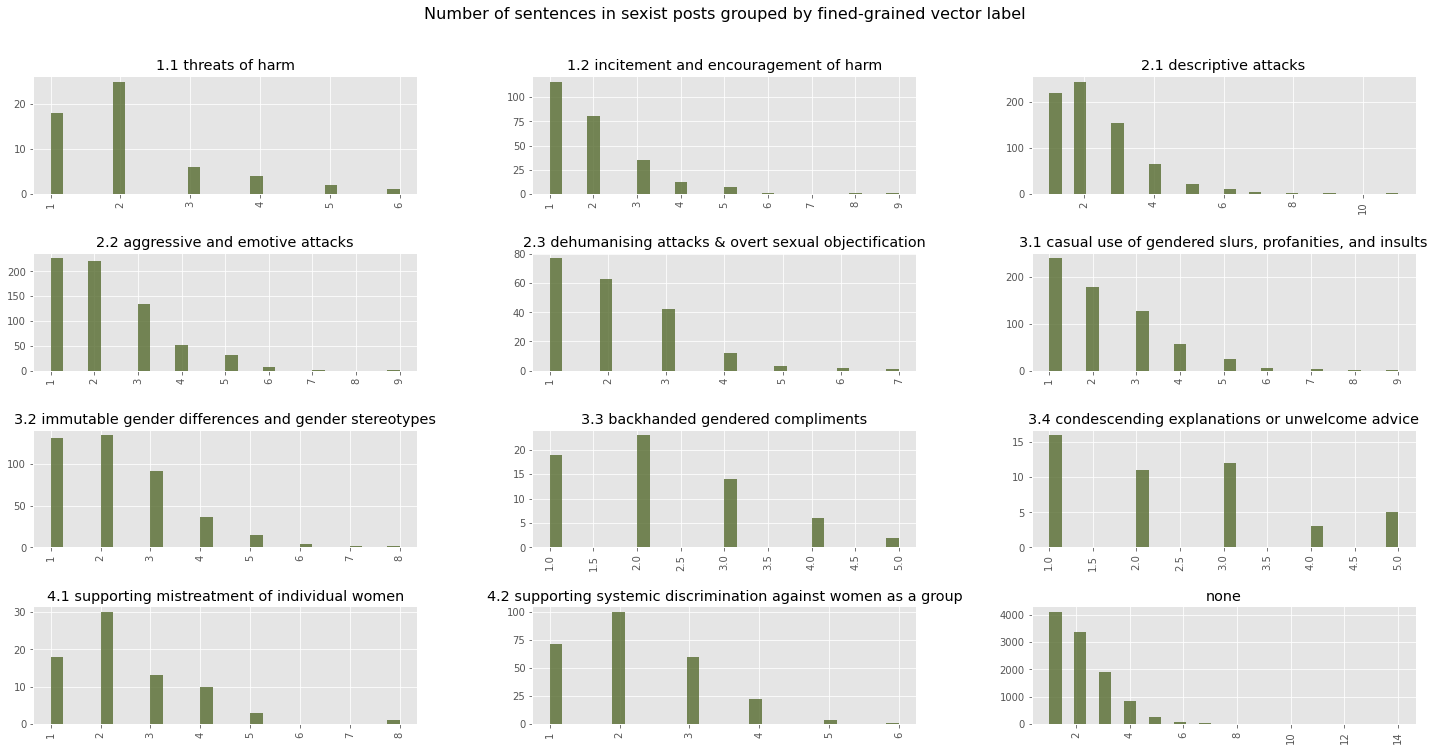

In [49]:
axes_subplot_list = train_data['sentences count'].hist(by = train_data['label_vector'], figsize=(24, 12), bins = 28, alpha = .8, color = 'darkolivegreen')
plt.suptitle('Number of sentences in sexist posts grouped by fined-grained vector label', fontsize = 16)
plt.show()

#### Test Data

##### Task A

Number of characters:

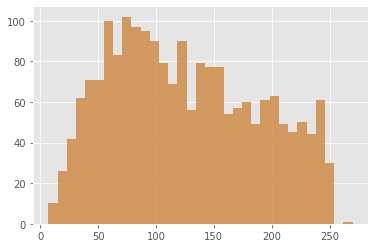

In [50]:
raw_test_data_taskA["text"].str.len().hist(grid=True, bins=33, color="peru", alpha=0.8)

In [51]:
test_data_taskA = raw_test_data_taskA.copy()

Statistical count features:

In [52]:
# total number of characters excluding whitespace and digits in train data
test_data_taskA["characters count"] = test_data_taskA["text"].apply(lambda x: len(x.replace("\d| |\n|\r|\r\n", "")))
# number of characters excluding special characters
test_data_taskA["excluded characters count"] = test_data_taskA["text"].apply(lambda x: len(x.replace(SPECIAL_CHARACTERS, "")))
# number of special characters
test_data_taskA["special characters count"] = test_data_taskA["text"].apply(lambda x: len([chr for chr in x if chr in SPECIAL_CHARACTERS]))
# number of words in train data
test_data_taskA["words count"] = test_data_taskA["text"].apply(lambda x: len(x.split()))
# mean words length
test_data_taskA["mean word length"] = test_data_taskA["text"].apply(lambda x: np.mean([len(word) for word in x]))
# number of sentences in train data
test_data_taskA["sentences count"] = test_data_taskA["text"].apply(lambda x: len(split_sentences(x)))
# mean sentence length
test_data_taskA["mean sentence length"] = test_data_taskA["text"].apply(lambda x: np.mean([len(sent) for sent in split_sentences(x)]))
# sentence density
test_data_taskA["sentences density"] = test_data_taskA["sentences count"] / test_data_taskA["words count"]

In [53]:
# total number of stopwords in the test data
test_data_taskA["stopwords count"] = test_data_taskA["text"].apply(lambda x: count_stopwords(x))

Analyze the distribution of features in plain text

In [54]:
test_data_taskA[['characters count', 'excluded characters count', 'special characters count', 'words count', 'mean word length', \
                'stopwords count', 'sentences count', 'mean sentence length', 'sentences density']].describe()

,characters count,excluded characters count,special characters count,words count,mean word length,stopwords count,sentences count,mean sentence length,sentences density
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.00000,2000.000000,2000.000000,2000.000000
mean,125.418500,125.418500,5.012500,23.008500,1.0,9.41100,2.045000,69.414038,0.106738
std,63.446711,63.446711,3.845873,11.799705,0.0,6.01433,1.140888,40.473225,0.075811
min,7.000000,7.000000,0.000000,1.000000,1.0,0.00000,1.000000,7.000000,0.020000
25%,73.750000,73.750000,2.000000,13.000000,1.0,5.00000,1.000000,42.000000,0.062500
50%,119.000000,119.000000,4.000000,21.500000,1.0,8.00000,2.000000,59.000000,0.090909
75%,176.000000,176.000000,7.000000,32.000000,1.0,14.00000,3.000000,85.000000,0.125000
max,270.000000,270.000000,32.000000,56.000000,1.0,31.00000,9.000000,250.000000,1.000000


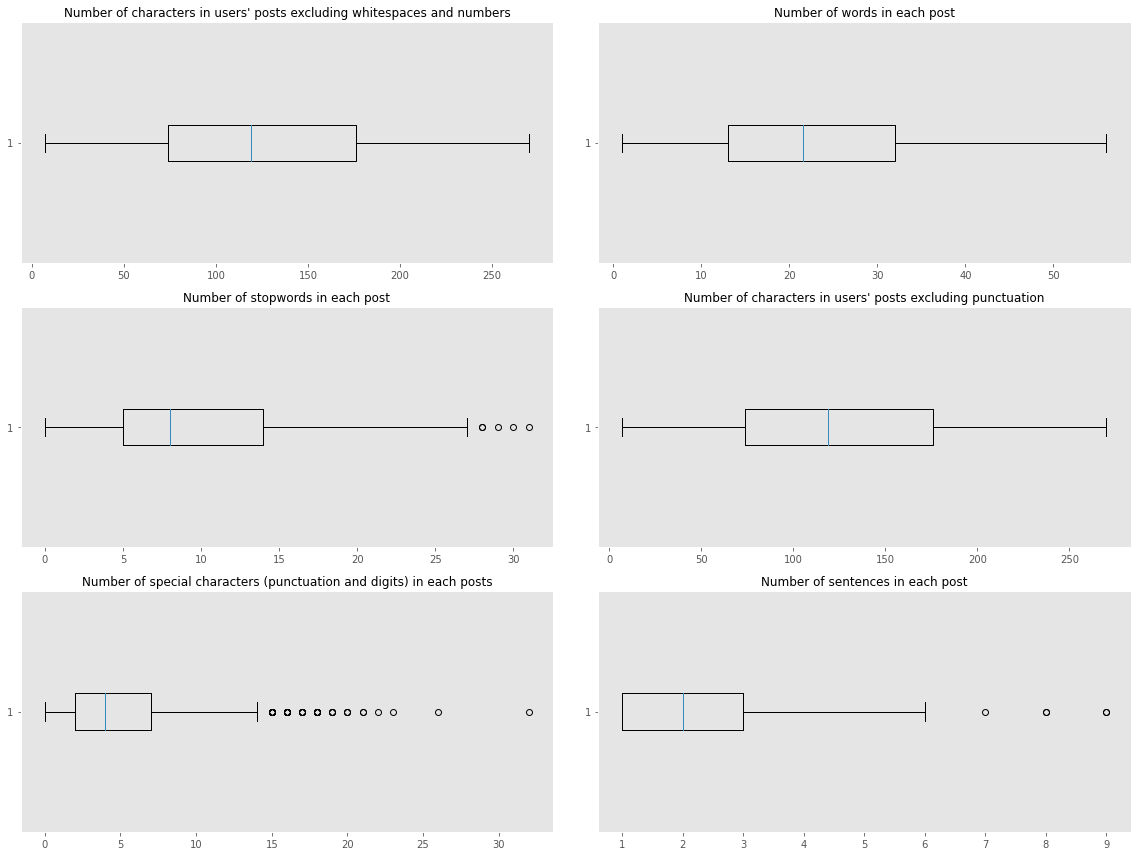

<Figure size 1152x7200 with 0 Axes>

In [55]:
fig, axes = plt.subplots(int(len(new_features) // 2), 2, figsize=(16, 12))

for idx, feature in enumerate(new_features):
  axes[idx % (len(new_features) // 2), idx % 2].grid(False)
  axes[idx % (len(new_features) // 2), idx % 2].set_title(new_features[feature], fontsize = 12)
  axes[idx % (len(new_features) // 2), idx % 2].boxplot(test_data_taskA[feature], vert = False)

fig.tight_layout()
plt.figure(figsize = (16, 100))
plt.show()

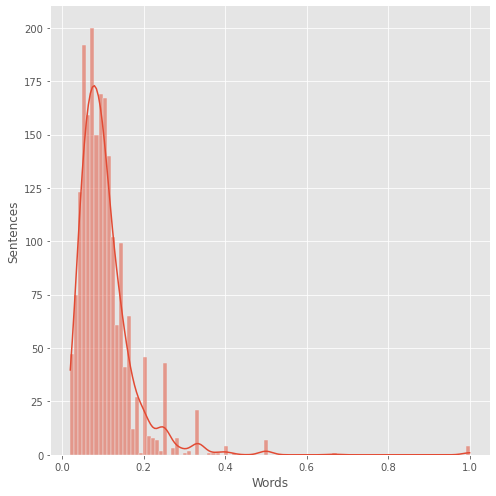

In [56]:
fig = sns.displot(test_data_taskA["sentences density"], kde=True, height=7)
plt.xlabel('Words')
plt.ylabel('Sentences')
plt.show()

In [57]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(test_data_taskA["text"].str.extractall(r'(\#\w+)')[0].value_counts())

#GabFam                    18
#MAGA                      15
#Trump                     7 
#News                      6 
#Hillary                   6 
#SpeakFreely               5 
#Gab                       3 
#PizzaGate                 3 
#x200B                     3 
#NSFW                      3 
#DrainTheSwamp             2 
#prostituta                2 
#amnesty                   2 
#Kavanaugh                 2 
#ISIS                      2 
#pizzagate                 2 
#Obama                     2 
#CrookedHillary            2 
#libtards                  2 
#HillaryForPrison          2 
#TeamSmut                  2 
#LockHerUp                 2 
#2A                        2 
#MGTOW                     2 
#topless                   2 
#WhiteGenocide             2 
#CrookedGoogle             1 
#Jews                      1 
#HillaryHatesAmericans     1 
#PNN                       1 
#America                   1 
#WaitingPatiently          1 
#RetardAlert               1 
#IVoteTrum

##### Task B

Number of characters:

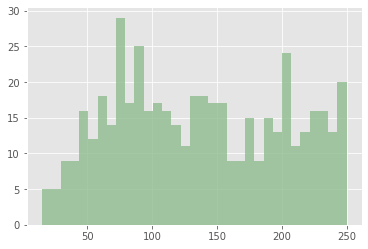

In [58]:
raw_test_data_taskB["text"].str.len().hist(grid=True, bins=33, color="darkseagreen", alpha=0.8)

In [59]:
test_data_taskB = raw_test_data_taskB.copy()

Analyze the distribution of features in plain text:

In [60]:
# total number of characters excluding whitespace and digits in train data
test_data_taskB["characters count"] = test_data_taskB["text"].apply(lambda x: len(x.replace("\d| |\n|\r|\r\n", "")))
# number of characters excluding special characters
test_data_taskB["excluded characters count"] = test_data_taskB["text"].apply(lambda x: len(x.replace(SPECIAL_CHARACTERS, "")))
# number of special characters
test_data_taskB["special characters count"] = test_data_taskB["text"].apply(lambda x: len([chr for chr in x if chr in SPECIAL_CHARACTERS]))
# number of words in train data
test_data_taskB["words count"] = test_data_taskB["text"].apply(lambda x: len(x.split()))
# mean words length
test_data_taskB["mean word length"] = test_data_taskB["text"].apply(lambda x: np.mean([len(word) for word in x]))
# number of sentences in train data
test_data_taskB["sentences count"] = test_data_taskB["text"].apply(lambda x: len(split_sentences(x)))
# mean sentence length
test_data_taskB["mean sentence length"] = test_data_taskB["text"].apply(lambda x: np.mean([len(sent) for sent in split_sentences(x)]))
# sentence density
test_data_taskB["sentences density"] = test_data_taskB["sentences count"] / test_data_taskB["words count"]

In [61]:
test_data_taskB["stopwords count"] = test_data_taskB["text"].apply(lambda x: count_stopwords(x))

In [62]:
test_data_taskB[['characters count', 'excluded characters count', 'special characters count', 'words count', 'mean word length', \
                 'stopwords count', 'sentences count', 'mean sentence length', 'sentences density']].describe()

,characters count,excluded characters count,special characters count,words count,mean word length,stopwords count,sentences count,mean sentence length,sentences density
count,486.000000,486.000000,486.000000,486.000000,486.0,486.000000,486.000000,486.000000,486.000000
mean,136.446502,136.446502,4.925926,25.024691,1.0,10.446502,2.172840,70.807739,0.098710
std,64.492117,64.492117,3.692102,11.942966,0.0,6.183468,1.195767,38.452598,0.053861
min,15.000000,15.000000,0.000000,3.000000,1.0,0.000000,1.000000,12.000000,0.020000
25%,80.250000,80.250000,2.000000,16.000000,1.0,6.000000,1.000000,45.625000,0.062500
50%,132.500000,132.500000,4.000000,24.000000,1.0,9.000000,2.000000,61.291667,0.090909
75%,195.000000,195.000000,7.000000,35.000000,1.0,15.000000,3.000000,84.750000,0.118697
max,250.000000,250.000000,26.000000,51.000000,1.0,30.000000,9.000000,250.000000,0.416667


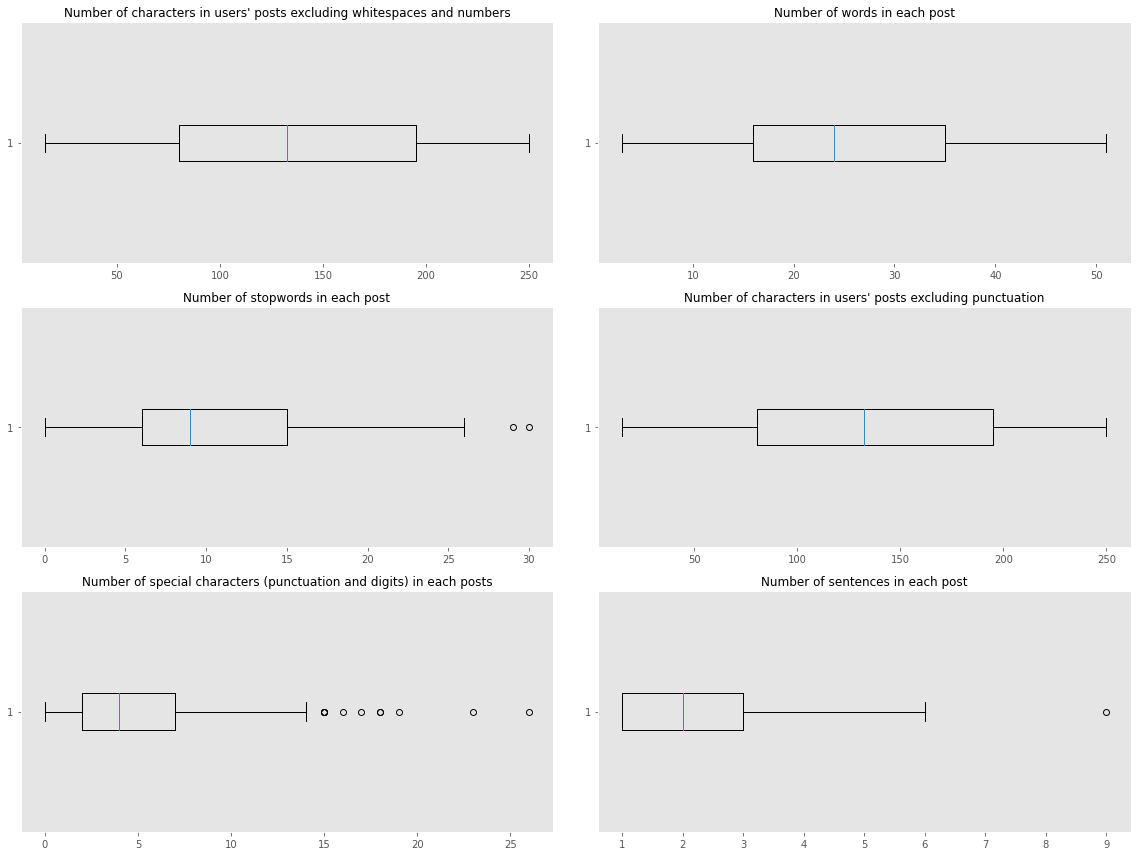

<Figure size 1152x7200 with 0 Axes>

In [63]:
fig, axes = plt.subplots(int(len(new_features) // 2), 2, figsize=(16, 12))

for idx, feature in enumerate(new_features):
  axes[idx % (len(new_features) // 2), idx % 2].grid(False)
  axes[idx % (len(new_features) // 2), idx % 2].set_title(new_features[feature], fontsize = 12)
  axes[idx % (len(new_features) // 2), idx % 2].boxplot(test_data_taskB[feature], vert = False)

fig.tight_layout()
plt.figure(figsize = (16, 100))
plt.show()

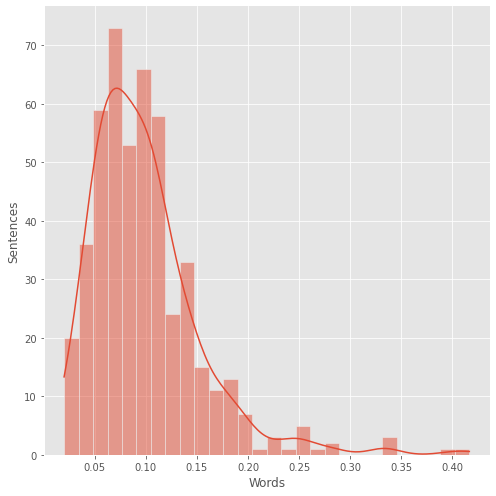

In [64]:
fig = sns.displot(test_data_taskB["sentences density"], kde=True, height=7)
plt.xlabel('Words')
plt.ylabel('Sentences')
plt.show()

Hastags from all test posts from task B:

In [65]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(test_data_taskB["text"].str.extractall(r'(\#\w+)')[0].value_counts())

#MGTOW                     2
#x200B                     2
#OnceASkankAlwaysASkank    1
#DrainTheSwamp             1
#WhiteGenocide             1
#Winning                   1
#RedneckNation             1
#DraintheSwamp             1
#irrational                1
#shield                    1
#FridayFeeling             1
#CaptainAmerica            1
#Femalenature              1
#Walkaway                  1
#HillaryHatesAmericans     1
#TradWifeism               1
#TranWifeIsTradWife        1
#shetakesherpillsdammit    1
#JustSaying                1
#GabFam                    1
#muted                     1
#metoo                     1
#QAlert                    1
#AIDS                      1
#MAGA                      1
#Hillary                   1
#RUDE                      1
#BeautifulNotSlutty        1
#NSFW                      1
#porn                      1
#erotica                   1
#girls                     1
#sexy                      1
#TeamSmut                  1
#TeamSlut     

##### Task C

Number of characters:

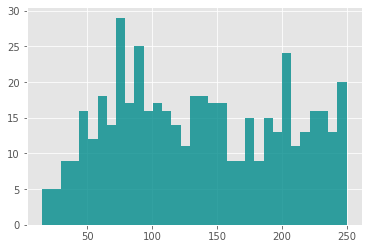

In [66]:
raw_test_data_taskC["text"].str.len().hist(grid=True, bins=33, color="darkcyan", alpha=0.8)

In [67]:
test_data_taskC = raw_test_data_taskC.copy()

Analyze the distribution of features in plain text

In [68]:
# total number of characters excluding whitespace and digits in test data task C
test_data_taskC["characters count"] = test_data_taskC["text"].apply(lambda x: len(x.replace("\d| |\n|\r|\r\n", "")))
# number of characters excluding special characters
test_data_taskC["excluded characters count"] = test_data_taskC["text"].apply(lambda x: len(x.replace(SPECIAL_CHARACTERS, "")))
# number of special characters
test_data_taskC["special characters count"] = test_data_taskC["text"].apply(lambda x: len([chr for chr in x if chr in SPECIAL_CHARACTERS]))
# number of words in test data task C
test_data_taskC["words count"] = test_data_taskC["text"].apply(lambda x: len(x.split()))
# mean words length
test_data_taskC["mean word length"] = test_data_taskC["text"].apply(lambda x: np.mean([len(word) for word in x]))
# number of sentences in test data task C
test_data_taskC["sentences count"] = test_data_taskC["text"].apply(lambda x: len(split_sentences(x)))
# mean sentence length
test_data_taskC["mean sentence length"] = test_data_taskC["text"].apply(lambda x: np.mean([len(sent) for sent in split_sentences(x)]))
# sentence density
test_data_taskC["sentences density"] = test_data_taskC["sentences count"] / test_data_taskC["words count"]
# stopwords count
test_data_taskC["stopwords count"] = test_data_taskC["text"].apply(lambda x: count_stopwords(x))

In [69]:
test_data_taskC[['characters count', 'excluded characters count', 'special characters count', 'words count', 'mean word length', \
                 'stopwords count', 'sentences count', 'mean sentence length', 'sentences density']].describe()

,characters count,excluded characters count,special characters count,words count,mean word length,stopwords count,sentences count,mean sentence length,sentences density
count,486.000000,486.000000,486.000000,486.000000,486.0,486.000000,486.000000,486.000000,486.000000
mean,136.446502,136.446502,4.925926,25.024691,1.0,10.446502,2.172840,70.807739,0.098710
std,64.492117,64.492117,3.692102,11.942966,0.0,6.183468,1.195767,38.452598,0.053861
min,15.000000,15.000000,0.000000,3.000000,1.0,0.000000,1.000000,12.000000,0.020000
25%,80.250000,80.250000,2.000000,16.000000,1.0,6.000000,1.000000,45.625000,0.062500
50%,132.500000,132.500000,4.000000,24.000000,1.0,9.000000,2.000000,61.291667,0.090909
75%,195.000000,195.000000,7.000000,35.000000,1.0,15.000000,3.000000,84.750000,0.118697
max,250.000000,250.000000,26.000000,51.000000,1.0,30.000000,9.000000,250.000000,0.416667


Extract hashtags from all test posts from task C:

In [70]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(test_data_taskC["text"].str.extractall(r'(\#\w+)')[0].value_counts())

#MGTOW                     2
#x200B                     2
#OnceASkankAlwaysASkank    1
#DrainTheSwamp             1
#WhiteGenocide             1
#Winning                   1
#RedneckNation             1
#DraintheSwamp             1
#irrational                1
#shield                    1
#FridayFeeling             1
#CaptainAmerica            1
#Femalenature              1
#Walkaway                  1
#HillaryHatesAmericans     1
#TradWifeism               1
#TranWifeIsTradWife        1
#shetakesherpillsdammit    1
#JustSaying                1
#GabFam                    1
#muted                     1
#metoo                     1
#QAlert                    1
#AIDS                      1
#MAGA                      1
#Hillary                   1
#RUDE                      1
#BeautifulNotSlutty        1
#NSFW                      1
#porn                      1
#erotica                   1
#girls                     1
#sexy                      1
#TeamSmut                  1
#TeamSlut     

### Analyze characteristics pertaining to part-of-speech

In [71]:
def get_pos_tags_counter(text_series):
  df = pd.DataFrame(columns = ['ADJ', 'ADP', 'ADV', 'CONV', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X'])

  for text in text_series:
    count_pos_tags = Counter([pos for _, pos in nltk.pos_tag(word_tokenize(text), tagset = 'universal')])
    df = df.append(count_pos_tags, ignore_index = True).fillna(0)

  return df.astype(int)

In [72]:
df_text_postags_train = get_pos_tags_counter(train_data["text"])
df_text_postags_train_notsexist = get_pos_tags_counter(train_data[train_data['label_sexist'] == 'not sexist']["text"])
df_text_postags_train_sexist = get_pos_tags_counter(train_data[train_data['label_sexist'] == 'sexist']["text"])

In [73]:
df_text_postags_train.describe()

,ADJ,ADP,ADV,CONV,DET,NOUN,NUM,PRT,PRON,VERB,.,X,CONJ
count,14000.000000,14000.00000,14000.000000,14000.0,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,1.839643,2.26900,1.744571,0.0,2.121286,6.702500,0.234214,0.832286,2.771786,5.261071,3.149571,0.045071,0.718714
std,1.606851,1.81384,1.660967,0.0,1.740999,4.319826,0.610818,1.015847,2.272554,3.265156,2.468587,0.219188,0.895189
min,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.00000,0.000000,0.0,1.000000,4.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000
50%,2.000000,2.00000,1.000000,0.0,2.000000,6.000000,0.000000,1.000000,2.000000,5.000000,3.000000,0.000000,0.000000
75%,3.000000,3.00000,3.000000,0.0,3.000000,9.000000,0.000000,1.000000,4.000000,7.000000,4.000000,0.000000,1.000000
max,12.000000,11.00000,11.000000,0.0,11.000000,68.000000,8.000000,7.000000,16.000000,19.000000,27.000000,3.000000,6.000000


In [ ]:
df_text_postags_train_notsexist.describe()

,ADJ,ADP,ADV,CONV,DET,NOUN,NUM,PRT,PRON,VERB,.,X,CONJ
count,10602.000000,10602.000000,10602.000000,10602.0,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000
mean,1.761649,2.231749,1.691096,0.0,2.039332,6.677608,0.237880,0.814563,2.744482,5.140634,3.119789,0.045463,0.705339
std,1.579174,1.801162,1.645538,0.0,1.720291,4.435432,0.612426,1.019730,2.276202,3.278296,2.488572,0.220642,0.893302
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.0,1.000000,4.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,0.0,2.000000,6.000000,0.000000,1.000000,2.000000,5.000000,3.000000,0.000000,0.000000
75%,3.000000,3.000000,3.000000,0.0,3.000000,9.000000,0.000000,1.000000,4.000000,7.000000,4.000000,0.000000,1.000000
max,11.000000,11.000000,11.000000,0.0,11.000000,67.000000,8.000000,7.000000,16.000000,19.000000,27.000000,3.000000,6.000000


In [74]:
df_text_postags_train_sexist.describe()

,ADJ,ADP,ADV,CONV,DET,NOUN,NUM,PRT,PRON,VERB,.,X,CONJ
count,3398.000000,3398.000000,3398.000000,3398.0,3398.000000,3398.000000,3398.000000,3398.000000,3398.000000,3398.000000,3398.000000,3398.000000,3398.000000
mean,2.082990,2.385227,1.911418,0.0,2.376986,6.780165,0.222778,0.887581,2.856975,5.636845,3.242496,0.043849,0.760447
std,1.667239,1.848289,1.697661,0.0,1.780250,3.936977,0.605722,1.001773,2.259347,3.195240,2.403154,0.214616,0.899907
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.0,1.000000,4.000000,0.000000,0.000000,1.000000,3.000000,2.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,0.0,2.000000,6.000000,0.000000,1.000000,2.000000,5.000000,3.000000,0.000000,1.000000
75%,3.000000,3.000000,3.000000,0.0,3.000000,9.000000,0.000000,1.000000,4.000000,8.000000,4.000000,0.000000,1.000000
max,12.000000,11.000000,11.000000,0.0,10.000000,68.000000,8.000000,6.000000,14.000000,16.000000,20.000000,2.000000,5.000000


In [75]:
pos_tags_labels = {
    'ADJ': 'Adjective',
    'ADP': 'Adposition',
    'ADV': 'Adverb',
    'CONJ': 'Conjuction',
    'DET': 'Determiner/Article',
    'NOUN': 'Noun',
    'NUM': 'Numeral',
    'PRT': 'Particle',
    'PRON': 'Pronoun',
    'VERB': 'Verb',
    '.': 'Punctuation mark',
    'X': 'Other'
}

In [87]:
def figure_pos_tags(df_text_postags, post_type = None): 
  fig, axes = plt.subplots(int(len(pos_tags_labels) / 3), 3, figsize = (16, 20), tight_layout = False)

  for nrow in range(int(len(pos_tags_labels) / 3)):
    for ncol in range(3):
      # Remove axes spines
      for spine in ['right', 'bottom', 'left', 'top']:
        axes[nrow, ncol].spines[spine].set_visible(False)

      # Remove x, y ticks
      axes[nrow, ncol].xaxis.set_ticks_position('none')
      axes[nrow, ncol].yaxis.set_ticks_position('none')

      # Add gridlines
      axes[nrow, ncol].grid(b = True,
                            color = 'cyan',
                            linestyle = '-.',
                            linewidth = 0.5,
                            alpha = 0.5)

  if post_type is None:
    fig.suptitle('Frequencies of pos tags per post', fontsize = 20, y = 1.02)
  else:
    fig.suptitle('Frequencies of pos tags per \'{}\' post'.format(post_type), fontsize = 20, y = 1.02)
  for idx, (label, title) in enumerate(pos_tags_labels.items()):
    if label not in df_text_postags.keys():
      continue 
      
    N, lower_limit, patches = axes[int(idx / 3), int(idx % 3)].hist(df_text_postags[label], bins = 15)

    fracs = ((N ** (1 / 4)) / N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())
    
    for current_frac, current_patch in zip(fracs, patches):
        color = plt.cm.viridis(norm(current_frac))
        current_patch.set_facecolor(color)
    
    axes[int(idx / 3), int(idx % 3)].set_title(title)
    axes[int(idx / 3), int(idx % 3)].set_xlabel('Part-of-speech tag')
    axes[int(idx / 3), int(idx % 3)].set_ylabel('POS frequencies')

    axes[int(idx / 3), int(idx % 3)].set_xlim([df_text_postags[label].min() - 1, df_text_postags[label].max() + 1])
    axes[int(idx / 3), int(idx % 3)].set_ylim([N.min(), N.max() + 5])

  fig.tight_layout()
  plt.show()

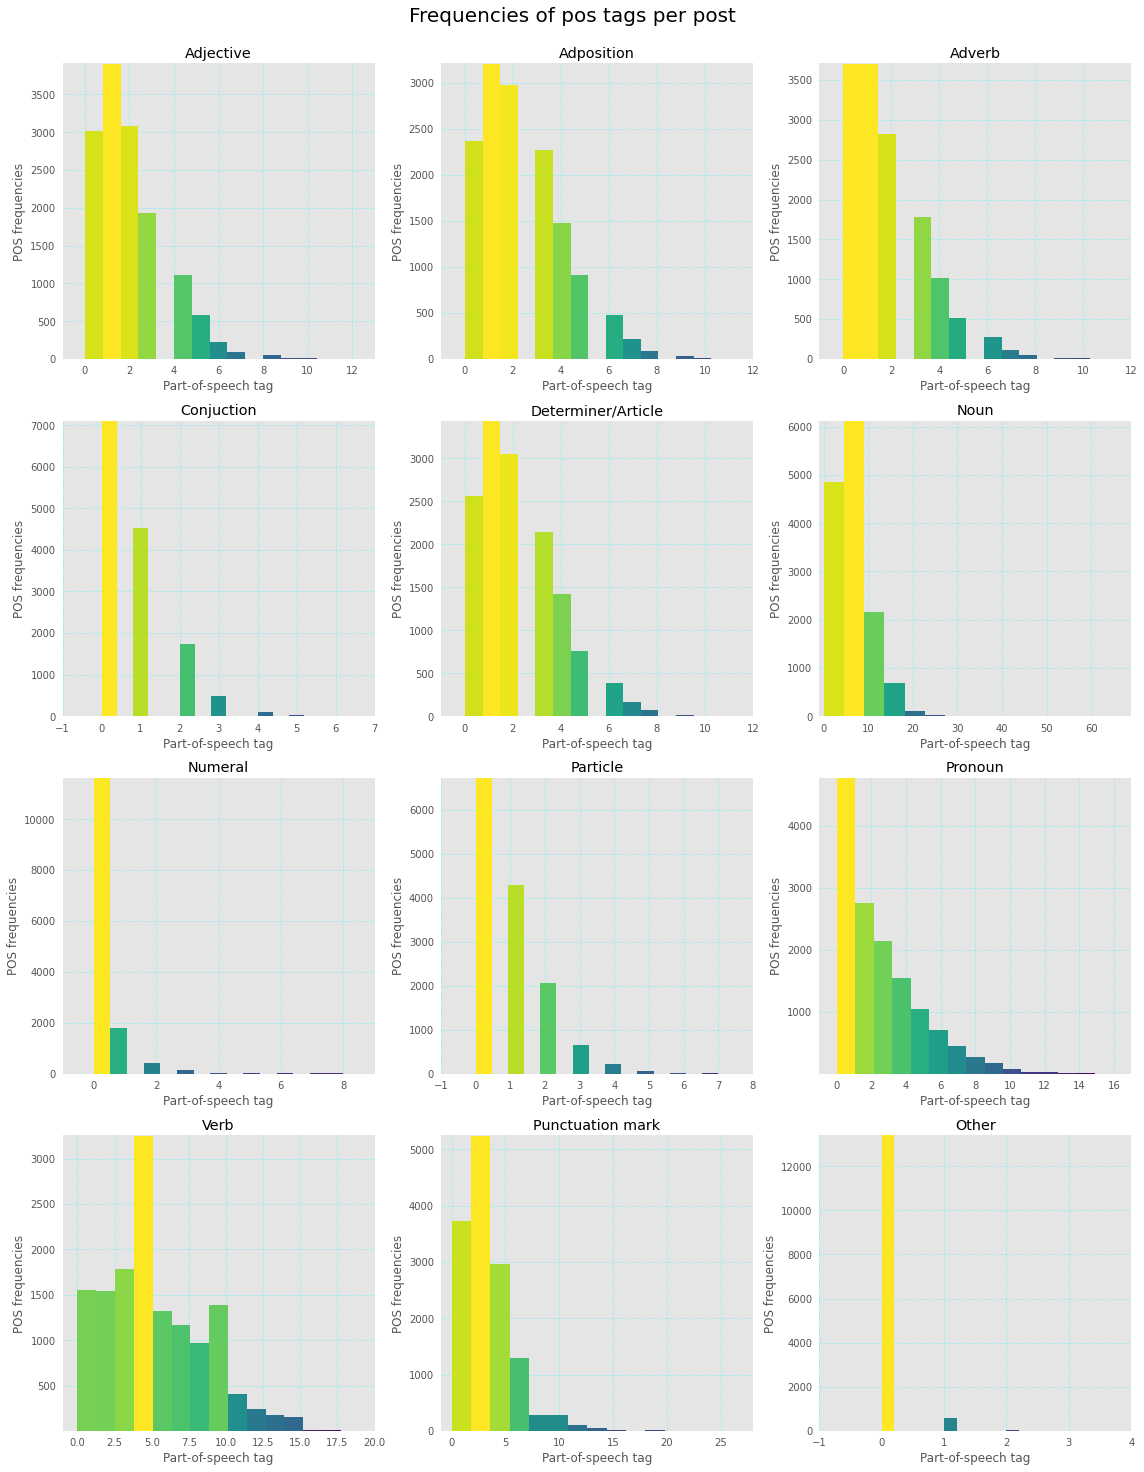

In [77]:
figure_pos_tags(df_text_postags_train)

#### Train Data - Task A

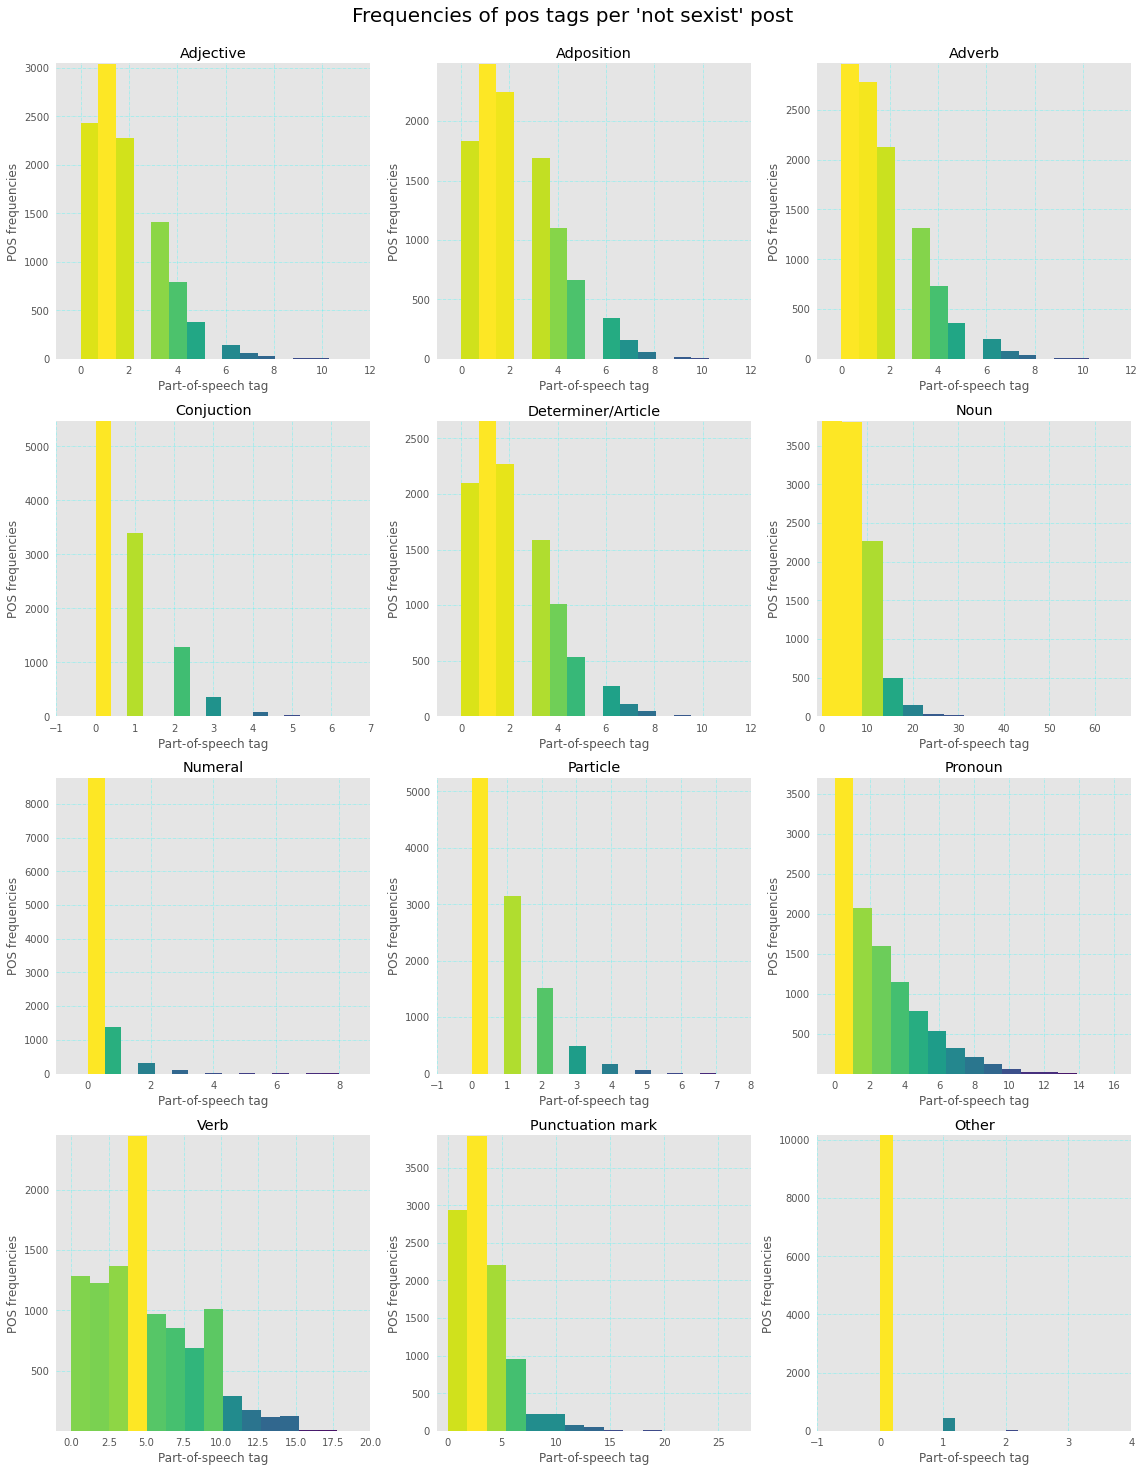

In [78]:
figure_pos_tags(df_text_postags_train_notsexist, 'not sexist')

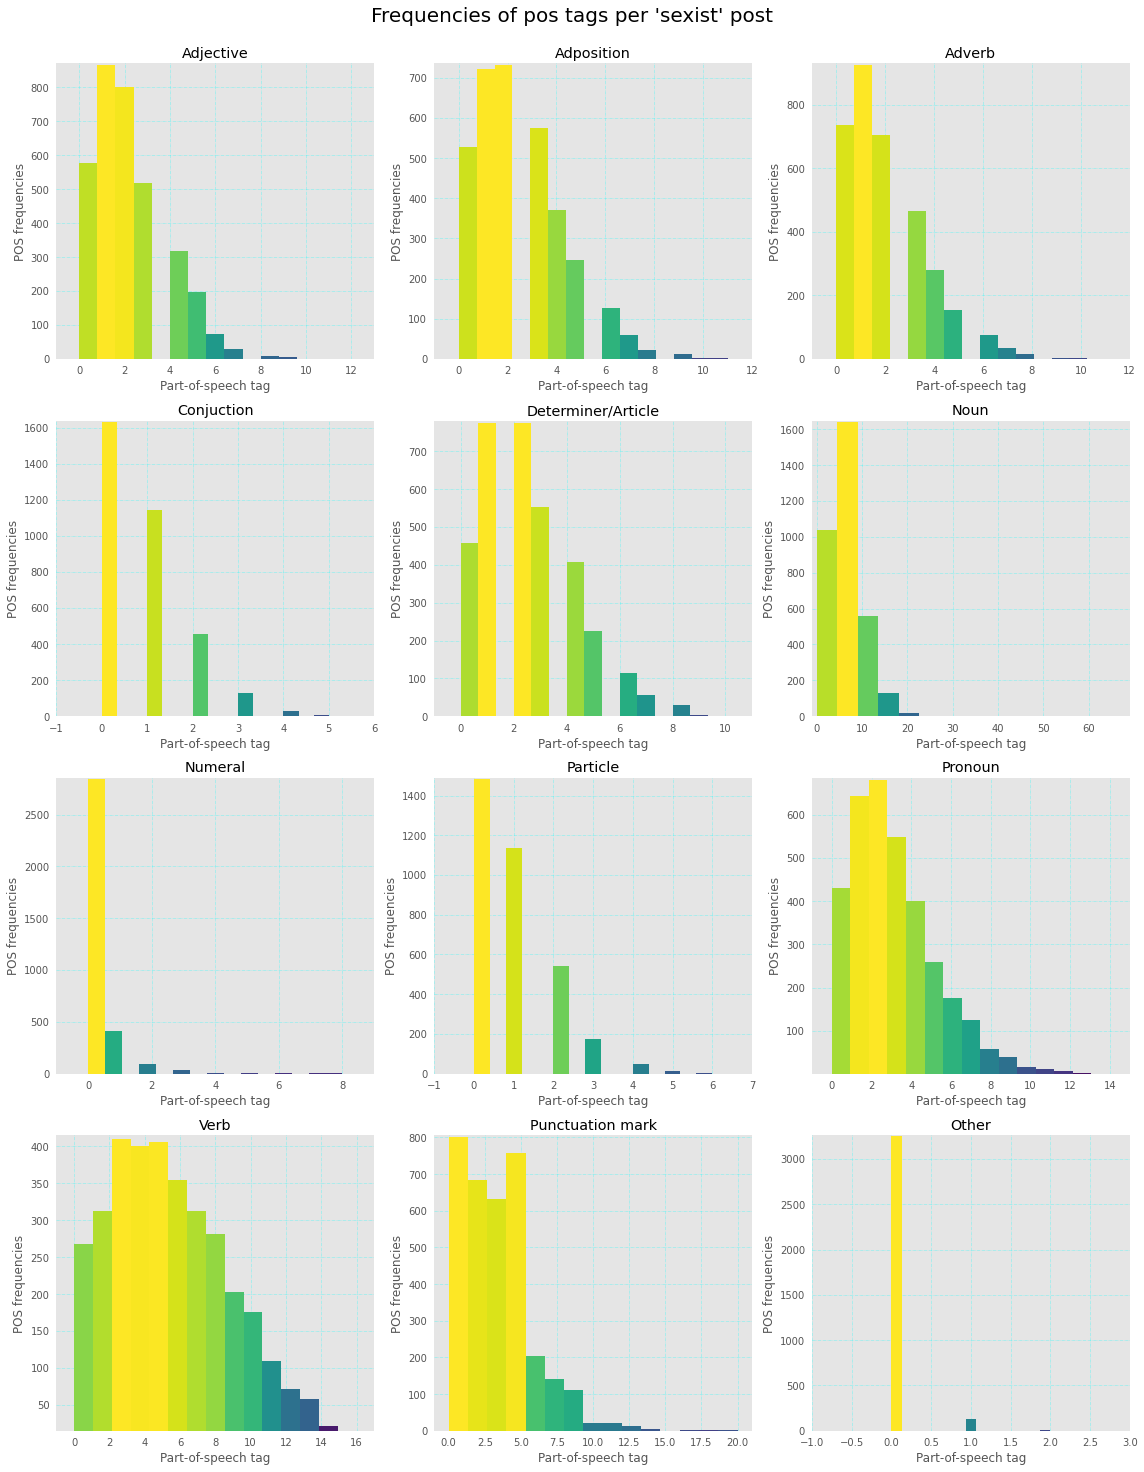

In [79]:
figure_pos_tags(df_text_postags_train_sexist, 'sexist')

#### Test Data

##### Task A

In [80]:
df_text_postags_test_taskA = get_pos_tags_counter(test_data_taskA)

In [82]:
df_text_postags_test_taskA.describe()

,ADJ,ADP,ADV,CONV,DET,NOUN,NUM,PRT,PRON,VERB,.,X
count,11.000000,11.0,11.0,11.0,11.0,11.000000,11.0,11.0,11.0,11.000000,11.0,11.0
mean,0.363636,0.0,0.0,0.0,0.0,1.636364,0.0,0.0,0.0,0.181818,0.0,0.0
std,0.504525,0.0,0.0,0.0,0.0,0.504525,0.0,0.0,0.0,0.404520,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0
75%,1.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0
max,1.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,1.000000,0.0,0.0


##### Task B

In [81]:
df_text_postags_test_taskB = get_pos_tags_counter(test_data_taskB)

In [83]:
df_text_postags_test_taskB.describe()

,ADJ,ADP,ADV,CONV,DET,NOUN,NUM,PRT,PRON,VERB,.,X
count,11.000000,11.0,11.0,11.0,11.0,11.000000,11.0,11.0,11.0,11.000000,11.0,11.0
mean,0.363636,0.0,0.0,0.0,0.0,1.636364,0.0,0.0,0.0,0.181818,0.0,0.0
std,0.504525,0.0,0.0,0.0,0.0,0.504525,0.0,0.0,0.0,0.404520,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0
75%,1.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0
max,1.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,1.000000,0.0,0.0


##### Task C

In [84]:
df_text_postags_test_taskC = get_pos_tags_counter(test_data_taskC)

In [85]:
df_text_postags_test_taskC.describe()

,ADJ,ADP,ADV,CONV,DET,NOUN,NUM,PRT,PRON,VERB,.,X
count,11.000000,11.0,11.0,11.0,11.0,11.000000,11.0,11.0,11.0,11.000000,11.0,11.0
mean,0.363636,0.0,0.0,0.0,0.0,1.636364,0.0,0.0,0.0,0.181818,0.0,0.0
std,0.504525,0.0,0.0,0.0,0.0,0.504525,0.0,0.0,0.0,0.404520,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0
75%,1.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0
max,1.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,1.000000,0.0,0.0


### Words frequency

##### Train Data

Most frequent words excluding stopwords

In [89]:
def clean_tokenize_text(text, stopwords):
  clean_text = re.sub(r'\W+', ' ', text)
  tokens = word_tokenize(clean_text)
  new_text = ' '.join([token.strip() for token in tokens if token.strip() not in stopwords])
  return new_text

In [90]:
train_text_preprocessed = raw_train_data['text'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

In [91]:
train_text_preprocessed_sexist = raw_train_data[raw_train_data['label_sexist'] == 'sexist']['text'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))
train_text_preprocessed_notsexist = raw_train_data[raw_train_data['label_sexist'] == 'not sexist']['text'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

WordCloud for user's posts:

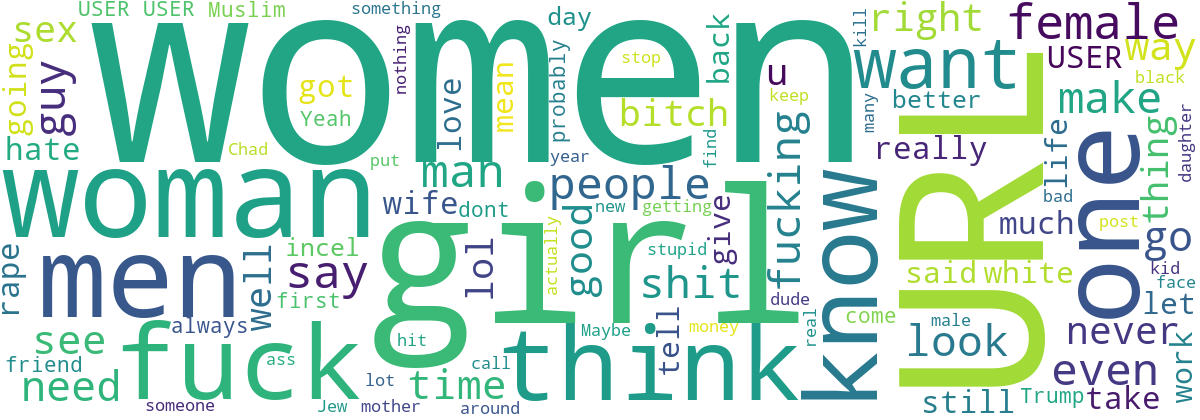

In [92]:
train_posts = ','.join(list(train_text_preprocessed.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1200, height = 420,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(train_posts)
wordcloud.to_image()

In [93]:
def get_top_nwords(corpus, num_words, n):
  count_vectorizer = CountVectorizer(stop_words='english',
                                     ngram_range=(n, n)).fit(corpus)
  bow = count_vectorizer.transform(corpus)
  sums = bow.sum(axis = 0)
  words_freq = [(word, sums[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

  return words_freq[:num_words]

Most common words in posts:

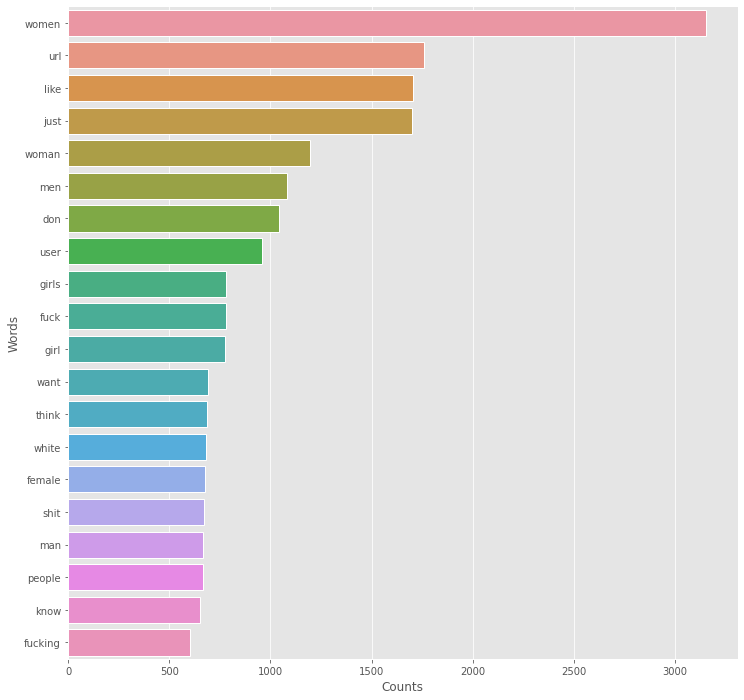

In [94]:
most_common_words = get_top_nwords(raw_train_data['text'], 20, 1)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

The most frequent two words joined:

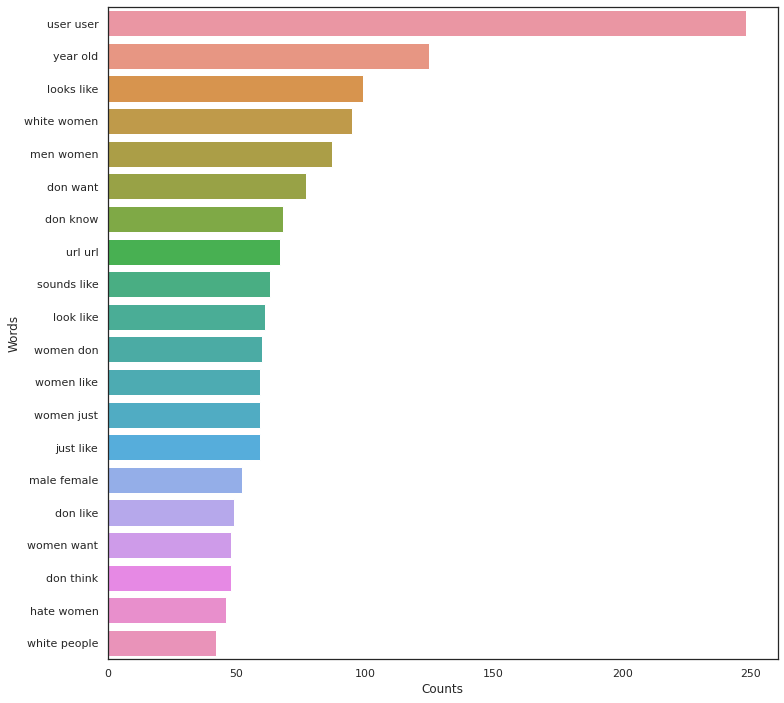

In [95]:
most_common_2words = get_top_nwords(raw_train_data['text'], 20, 2)
common_2words_df = pd.DataFrame(most_common_2words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_2words_df['Counts'], y = common_2words_df['Words'])

The most frequent three words joined:

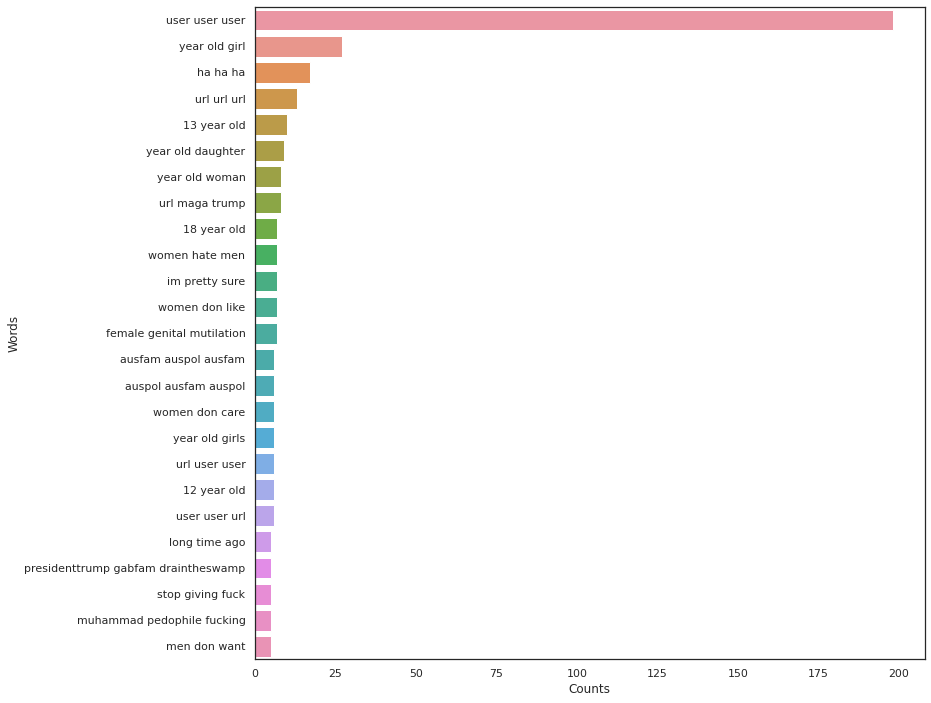

In [96]:
most_common_3words = get_top_nwords(raw_train_data['text'], 25, 3)
common_3words_df = pd.DataFrame(most_common_3words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_3words_df['Counts'], y = common_3words_df['Words'])

WordCloud for sexist users' posts:

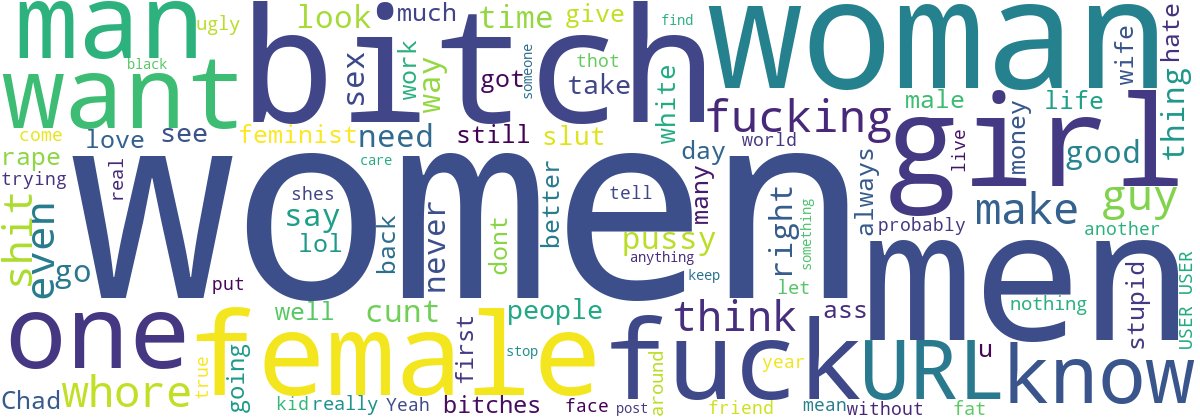

In [97]:
train_sexist_posts = ','.join(list(train_text_preprocessed_sexist.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1200, height = 420,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(train_sexist_posts)
wordcloud.to_image()

WordCloud for 'not sexist' users' posts:

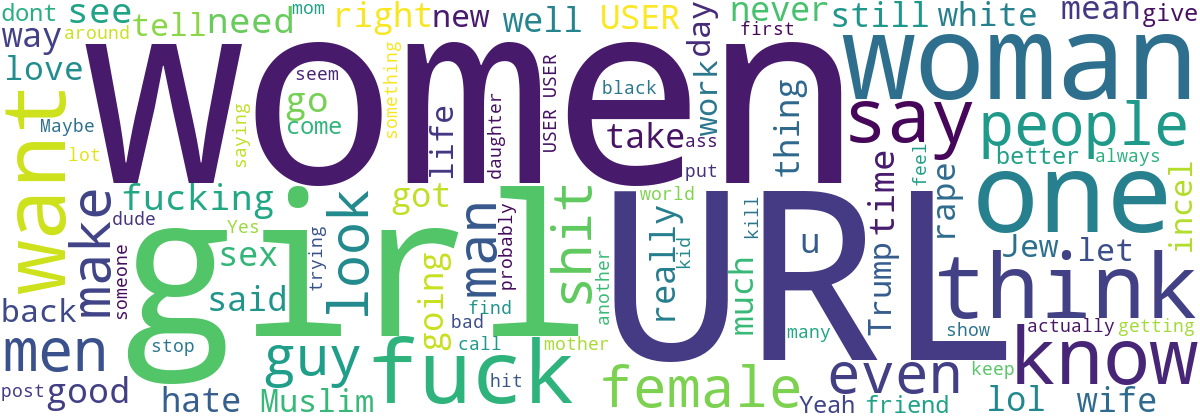

In [98]:
train_notsexist_posts = ','.join(list(train_text_preprocessed_notsexist.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1200, height = 420,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(train_notsexist_posts)
wordcloud.to_image()

Most common words in sexist posts:

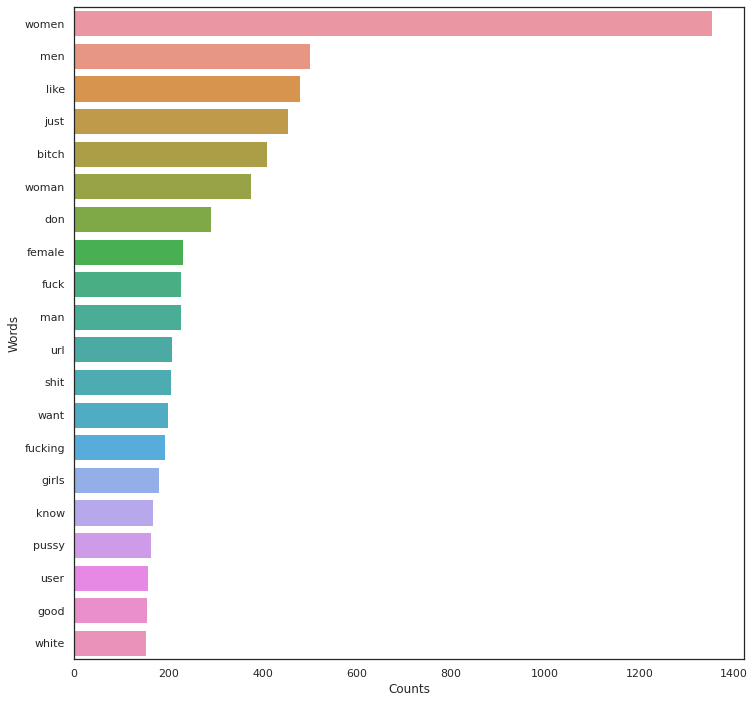

In [99]:
most_common_words = get_top_nwords(raw_train_data[raw_train_data['label_sexist'] == 'sexist']['text'], 20, 1)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

The most frequent two words joined in sexist posts:

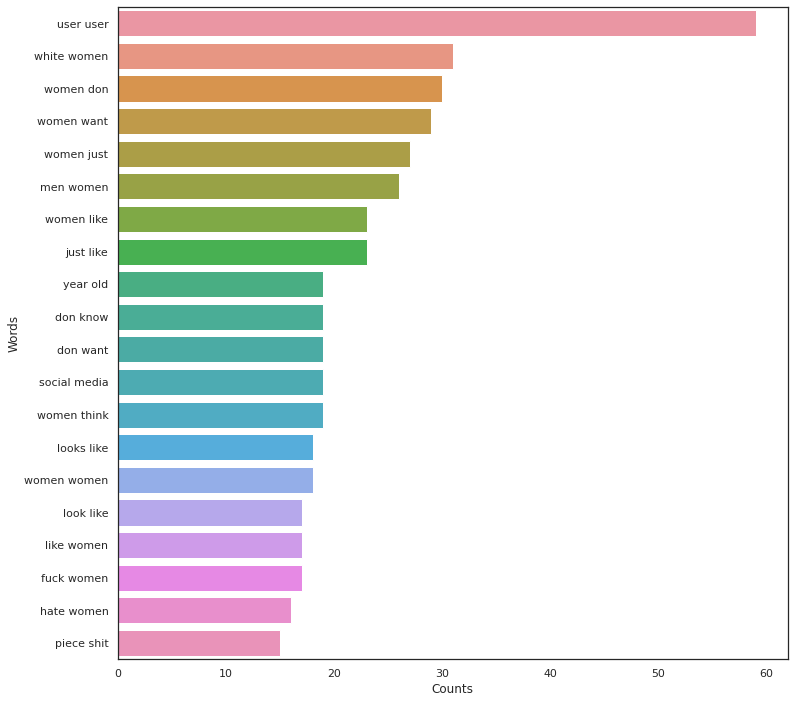

In [110]:
most_2common_words = get_top_nwords(raw_train_data[raw_train_data['label_sexist'] == 'sexist']['text'], 20, 2)
common_2words_df = pd.DataFrame(most_2common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_2words_df['Counts'], y = common_2words_df['Words'])

The most frequent three words joined in sexist posts:

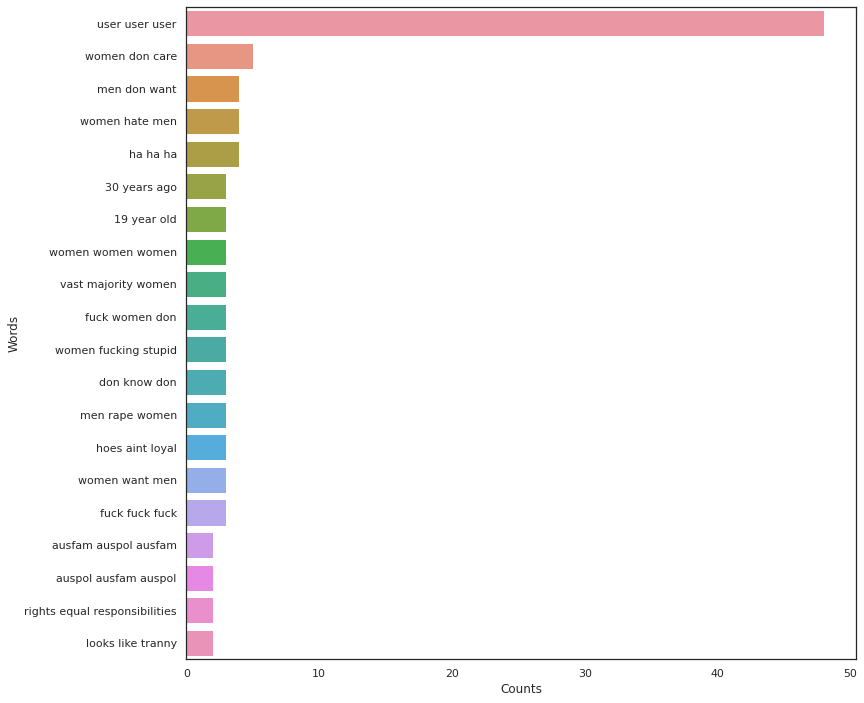

In [ ]:
most_3common_words = get_top_nwords(raw_train_data[raw_train_data['label_sexist'] == 'sexist']['text'], 20, 3)
common_3words_df = pd.DataFrame(most_3common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_3words_df['Counts'], y = common_3words_df['Words'])

##### Test Data

Most frequent words excluding stopwords

In [105]:
test_taskA_text_preprocessed = raw_test_data_taskA['text'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))
test_taskB_text_preprocessed = raw_test_data_taskB['text'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))
test_taskC_text_preprocessed = raw_test_data_taskC['text'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

WordCloud for user's posts from test data

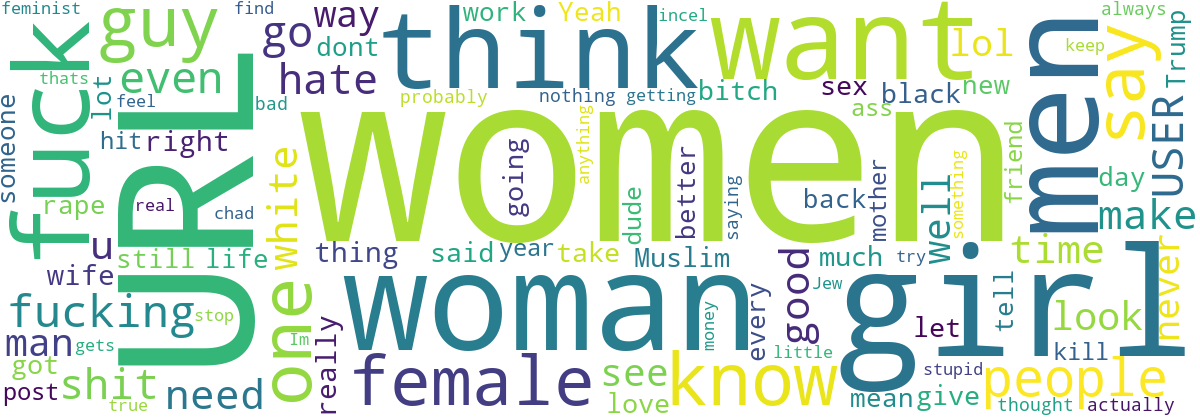

In [103]:
# TASK A
test_posts_taskA = ','.join(list(test_taskA_text_preprocessed.values))
wordcloud = WordCloud(max_words=100,
                      width=1200, height=420,
                      contour_width=2, background_color='white')
wordcloud.generate(test_posts_taskA)
wordcloud.to_image()

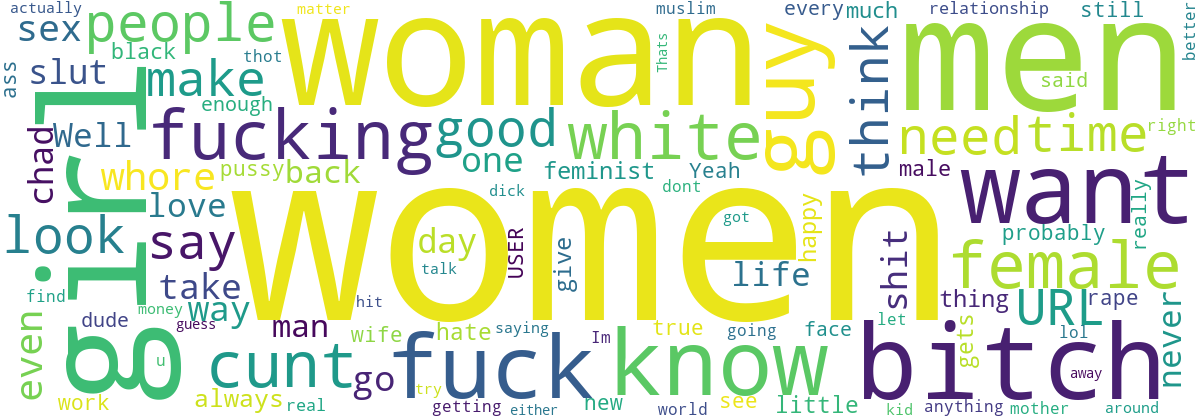

In [107]:
# TASK B
test_posts_taskB = ','.join(list(test_taskB_text_preprocessed.values))
wordcloud = WordCloud(max_words=100,
                      width=1200, height=420,
                      contour_width=2, background_color='white')
wordcloud.generate(test_posts_taskB)
wordcloud.to_image()

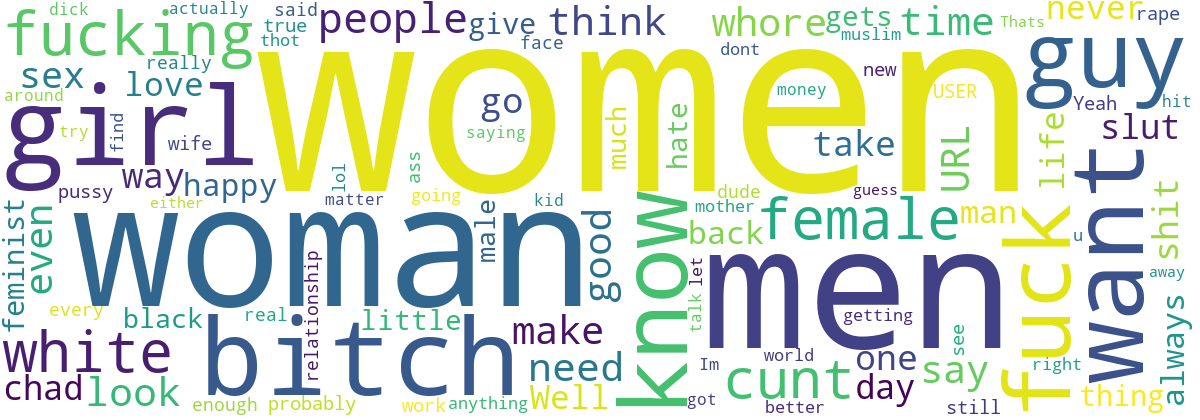

In [109]:
# TASK C
test_posts_taskC = ','.join(list(test_taskC_text_preprocessed.values))
wordcloud = WordCloud(max_words=100,
                      width=1200, height=420,
                      contour_width=2, background_color='white')
wordcloud.generate(test_posts_taskC)
wordcloud.to_image()

Most common words in Task A:

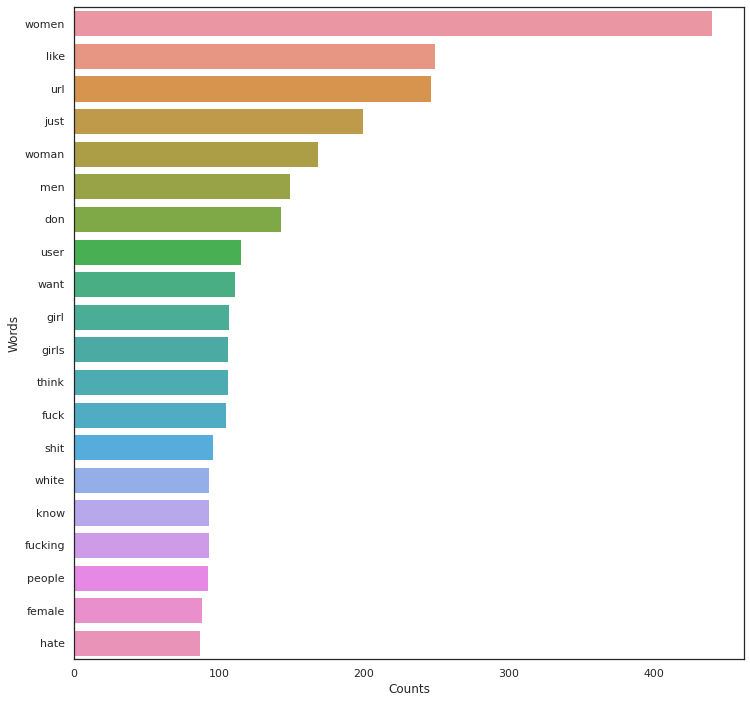

In [111]:
most_common_words = get_top_nwords(raw_test_data_taskA['text'], 20, 1)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

Most common words in Task B:

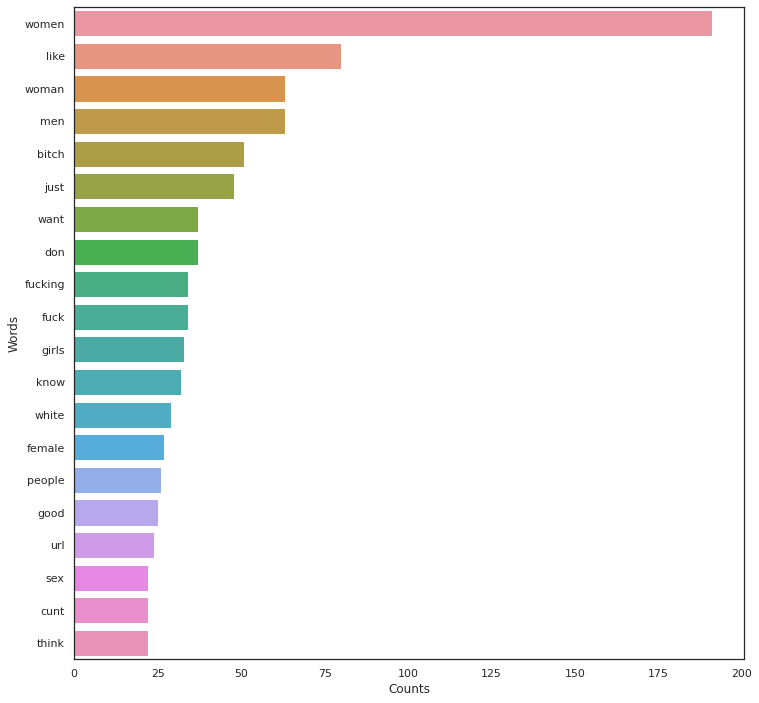

In [113]:
most_common_words = get_top_nwords(raw_test_data_taskB['text'], 20, 1)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

Most common words in Task C

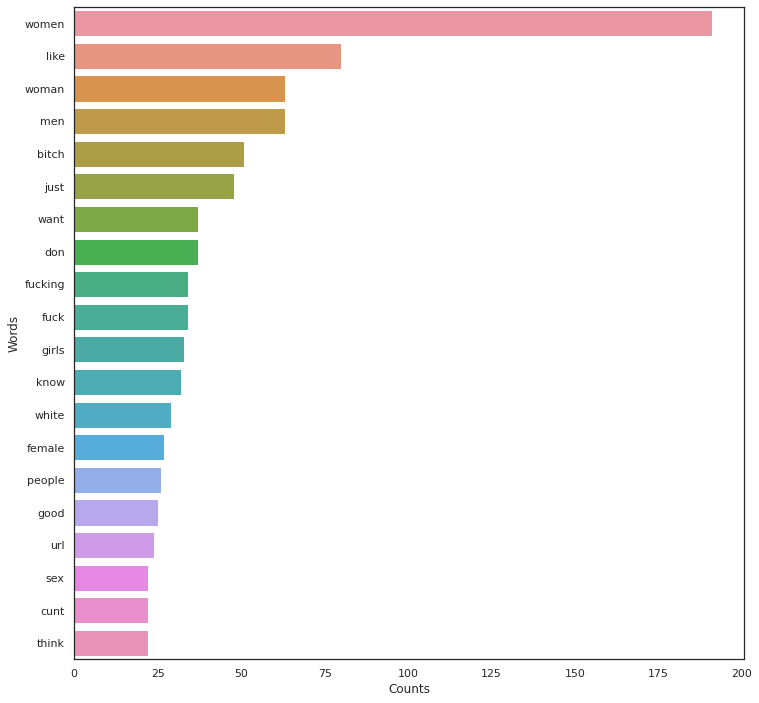

In [114]:
most_common_words = get_top_nwords(raw_test_data_taskC['text'], 20, 1)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

Most frequent two words joined in Task A test data:

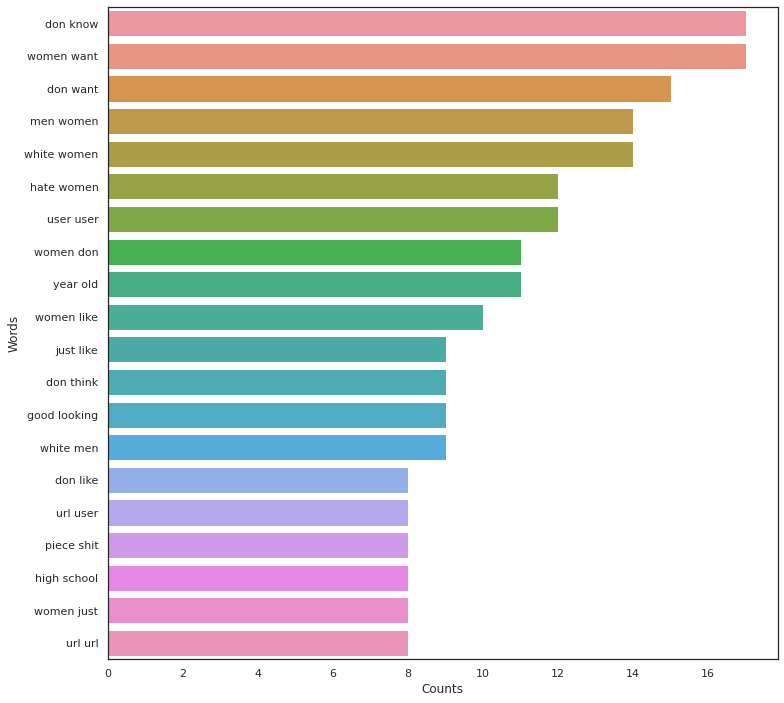

In [116]:
most_common_words = get_top_nwords(raw_test_data_taskA['text'], 20, 2)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

Most frequent two words joined in Task B test data:

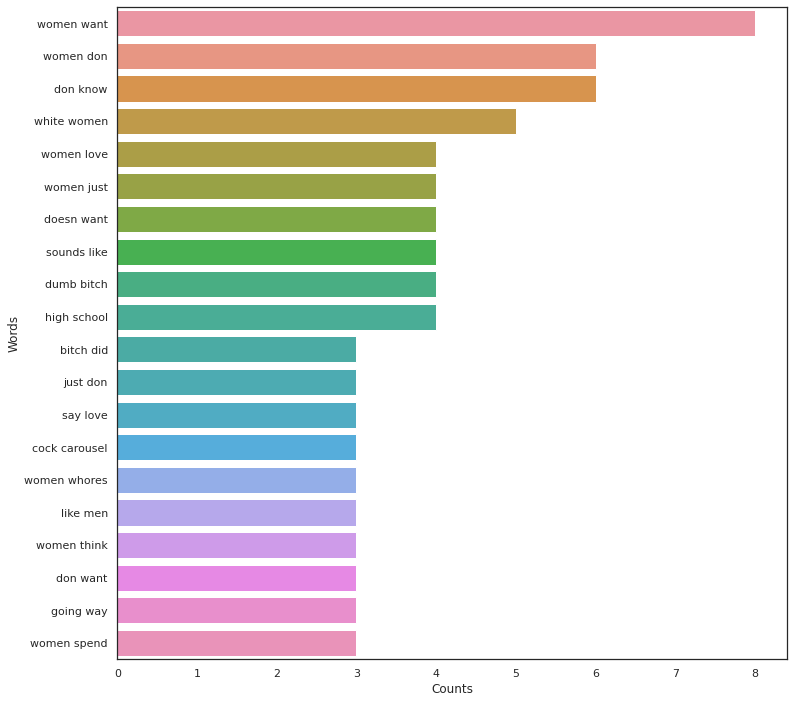

In [117]:
most_common_words = get_top_nwords(raw_test_data_taskA['text'], 20, 2)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

Most frequent two words joined in Task C test data:

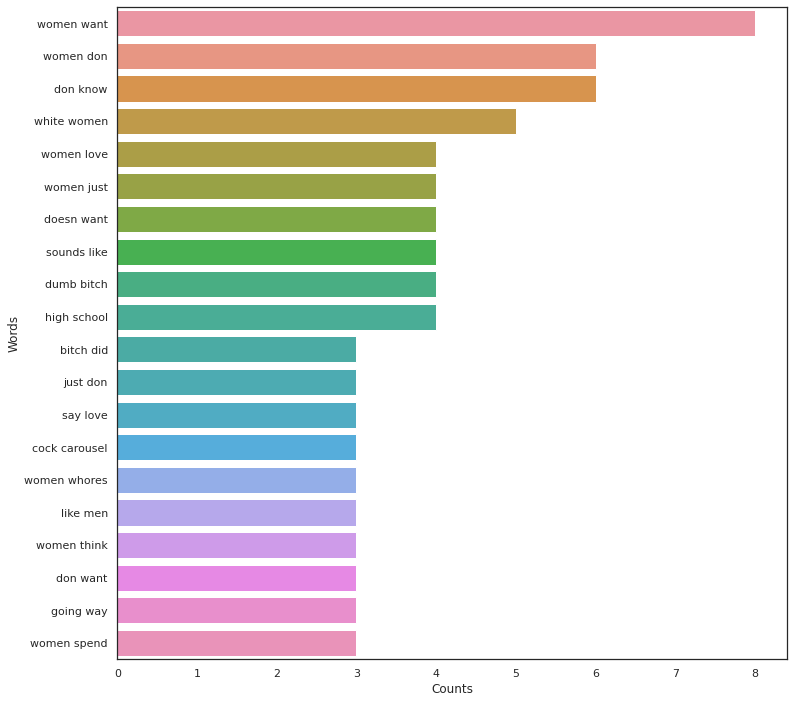

In [118]:
most_common_words = get_top_nwords(raw_test_data_taskC['text'], 20, 2)
common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

Most frequent two words joined in Task A test data:

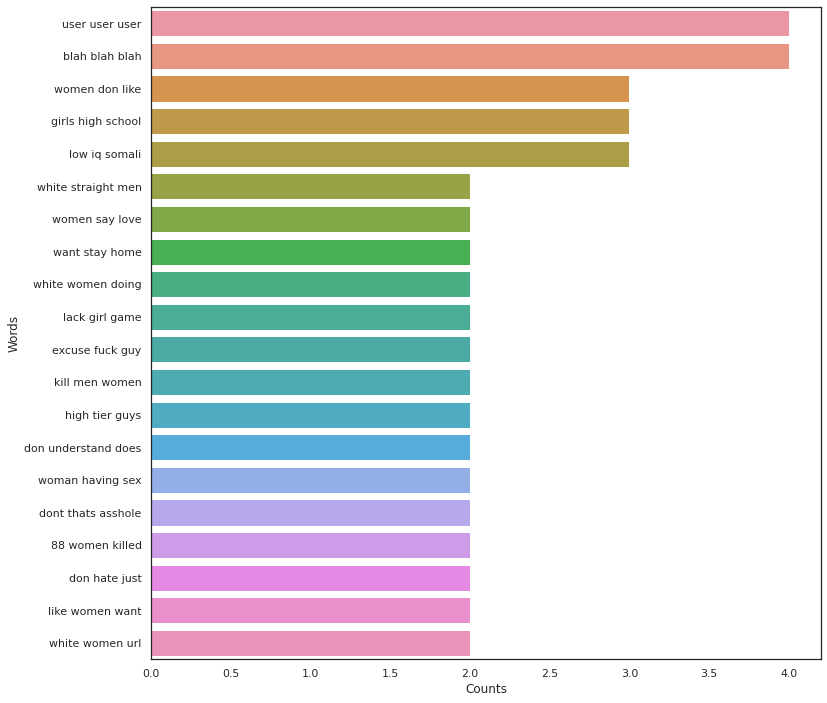

In [125]:
most_common_3words = get_top_nwords(raw_test_data_taskA['text'], 20, 3)
common_3words_df = pd.DataFrame(most_common_3words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_3words_df['Counts'], y = common_3words_df['Words'])

Most frequent two words joined in Task C test data:

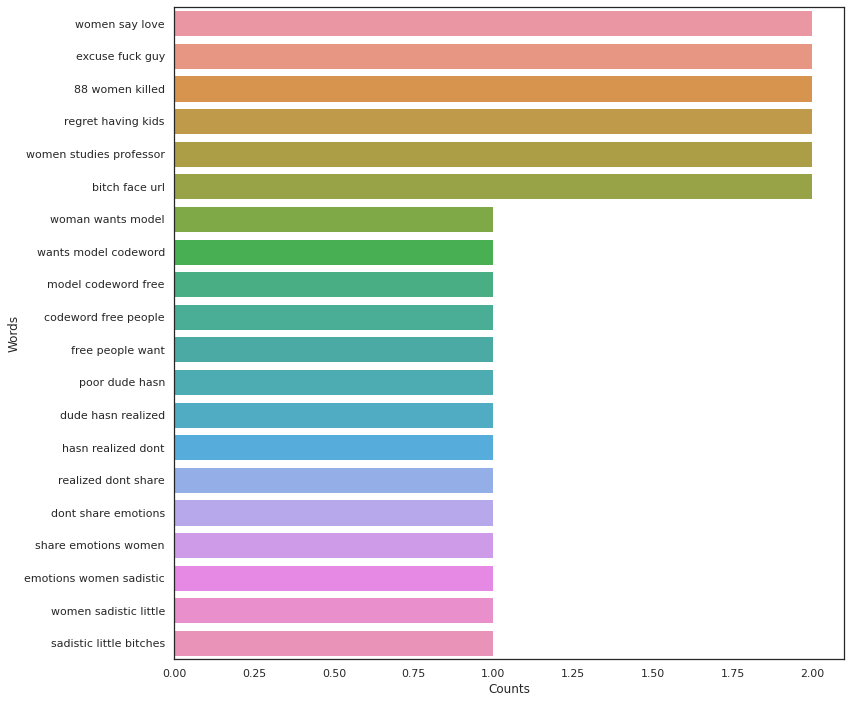

In [126]:
most_common_3words = get_top_nwords(raw_test_data_taskB['text'], 20, 3)
common_3words_df = pd.DataFrame(most_common_3words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_3words_df['Counts'], y = common_3words_df['Words'])

Most frequent two words joined in Task C test data:

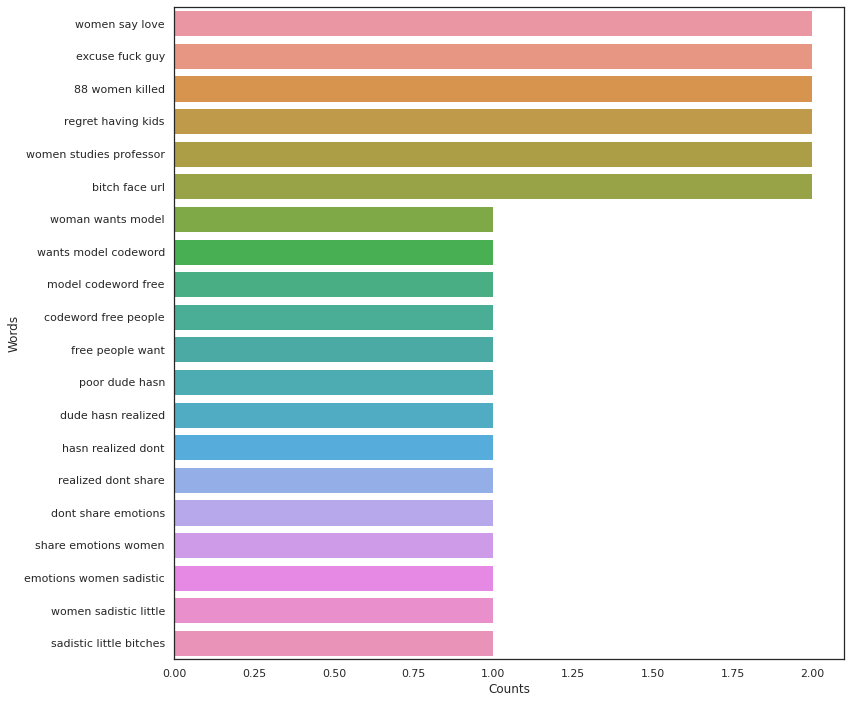

In [127]:
most_common_3words = get_top_nwords(raw_test_data_taskC['text'], 20, 3)
common_3words_df = pd.DataFrame(most_common_3words, columns = ['Words', 'Counts'])

plt.subplots(figsize = (12, 12))
sns.set_theme(style = 'white')
sns.barplot(x = common_3words_df['Counts'], y = common_3words_df['Words'])

## Baselines

### Logistic Regression

##### Data Preprocessing

Beginning with a standard text cleaning procedure, we will then adapt the data preprocessing phase to our task and compare the results. A standard text cleaning process involves the following steps:


1.   Lowercase
2.   Removal of special characters (punctuations and numbers)
3.   Removal of extra whitespaces
4.   Removal of tags
5.   Removal of stop words
6.   Stemming/Lemmatizing (reducing inflexional forms to their root)



In [151]:
lemmatizer = WordNetLemmatizer()

cleaning_filters = [
    gsp.strip_tags,
    gsp.strip_punctuation2,
    gsp.strip_multiple_whitespaces,
    gsp.strip_numeric,
    gsp.remove_stopwords,
    gsp.strip_short,
]

def clean_text(text):
  text = text.lower()
  for filter in cleaning_filters:
    text = filter(text)
  lemmas = [lemmatizer.lemmatize(t) for t in word_tokenize(text)]
  text = ' '.join(lemmas)

  return text

In [156]:
train_data_text = raw_train_data["text"].copy()
test_data_text_taskA = raw_test_data_taskA["text"].copy()
test_data_text_taskB = raw_test_data_taskB["text"].copy()
test_data_text_taskC = raw_test_data_taskC["text"].copy()

##### Vectorization

In [198]:
class TfIdfVectorizerTransform(BaseEstimator):
  def __init__(self):
    self._vectorizer = TfidfVectorizer()
    pass

  def fit(self, df_x, df_y=None):
    df_x = df_x.apply(lambda x: clean_text(x))
    self._vectorizer.fit(df_x)
    return self

  def transform(self, df_x):
    df_x = df_x.apply(lambda x: clean_text(x))
    return self._vectorizer.transform(df_x)

In [199]:
tfidf_vectorizer = TfIdfVectorizerTransform()

text_train_vectorized = tfidf_vectorizer.fit(train_data_text).transform(train_data_text)
text_test_taskA_vectorized = tfidf_vectorizer.transform(test_data_text_taskA)
text_test_taskB_vectorized = tfidf_vectorizer.transform(test_data_text_taskB)
text_test_taskC_vectorized = tfidf_vectorizer.transform(test_data_text_taskC)

In [200]:
text_train_vectorized.shape

(14000, 18039)

In [201]:
text_test_taskA_vectorized.shape

(2000, 18039)

In [202]:
text_test_taskB_vectorized.shape

(486, 18039)

In [203]:
text_test_taskC_vectorized.shape

(486, 18039)

#### Building the classification pipelines

In [225]:
pipeline_tfidf_logreg = Pipeline(steps=[('tfidf_vectorizer', TfIdfVectorizerTransform()),
                                        ('logistic_regression', LogisticRegression())])

scores = cross_validate(pipeline_tfidf_logreg, train_data_text, raw_train_data["label_sexist"], cv=5, \
                        scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'])

In [226]:
scores

{'fit_time': array([5.29309869, 5.370713  , 5.36197662, 5.2327137 , 5.27134728]),
 'score_time': array([0.70152998, 0.70006919, 0.68728948, 0.68861127, 0.68927646]),
 'test_accuracy': array([0.81964286, 0.82785714, 0.81821429, 0.82642857, 0.82178571]),
 'test_balanced_accuracy': array([0.65266092, 0.66959759, 0.64671199, 0.66312431, 0.65656215]),
 'test_f1_weighted': array([0.78894383, 0.80106815, 0.78518005, 0.79730327, 0.79176612])}

#### Hyperparameter tuning

### XGBoost

### NuSVM

### BERT